# DE data analysis

We study the active noise of confined bacterial suspensions. The experiment is conducted in an oil-water-oil (OWO) double emulsion system as sketched below. *E. coli* bacteria swim in the "shell" between two oil phases. The inner oil droplets are pushed around by swimming bacteria. We are interested in the physical nature of the active noise induced by independent/collective motions of bacteria, as well as how active noise depends on confinement. 

In [3]:
from myimagelib.deLib import de_data
import pandas as pd
import os
import matplotlib.pyplot as plt
from myimagelib.myImageLib import bestcolor, gauss1, readdata
import numpy as np
from scipy.optimize import curve_fit
import trackpy as tp
from matplotlib.patches import Ellipse, Circle
from myimagelib.corrLib import autocorr1d
from IPython.display import clear_output
from scipy.ndimage import gaussian_filter1d
from matplotlib import colors, cm
from nd2reader import ND2Reader
from tifffile import imwrite
from skimage import io
from imutils import rotate
from matplotlib import rcParams
import matplotlib
rcParams["text.usetex"] = False
rcParams['font.family'] = 'sans-serif'
# rcParams['font.family'] = 'Times New Roman'
rcParams['font.sans-serif'] = ['DejaVu Sans']
import shutil

## 0 Parameter space

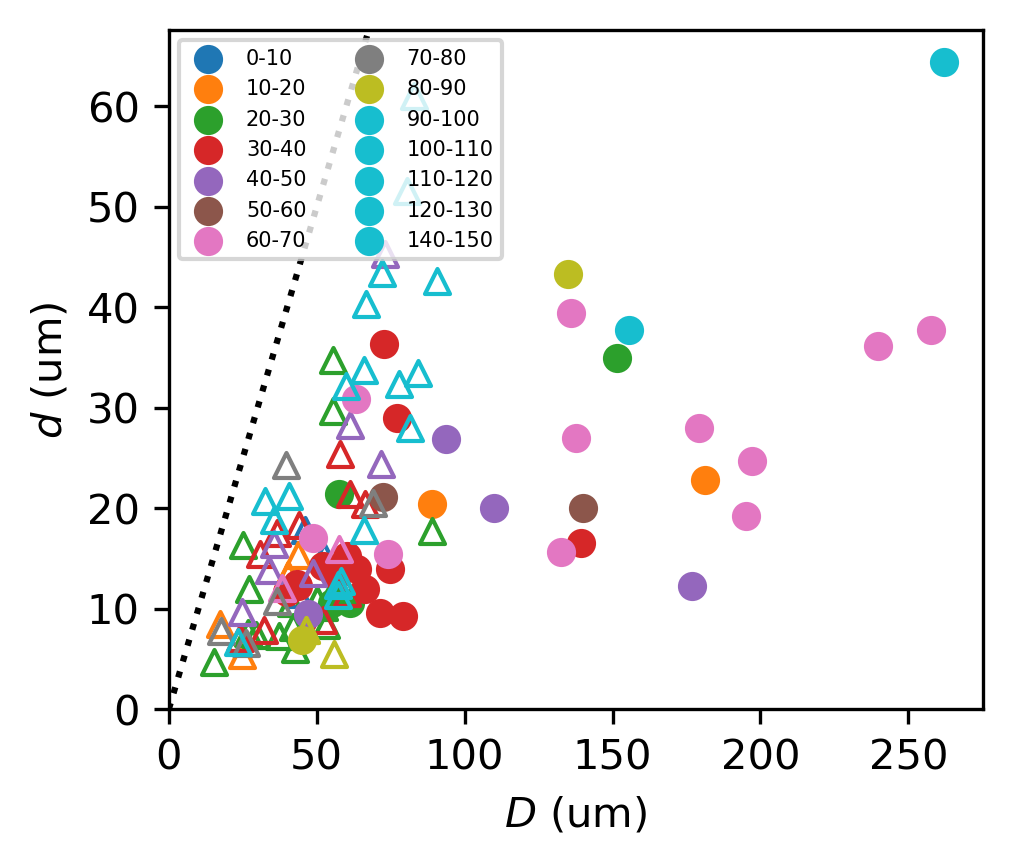

In [3]:
# load log file
data_folder = r"..\Data"
log = pd.read_excel(io=os.path.join(data_folder, "structured_log_DE.ods")).set_index("DE#")

# filter out Chile data
log1 = log.loc[(log.Fitting!="bad")&(log.Move!=1)]
dd = de_data(log1)

dd.parameter_space()
# plt.scatter(log_new.D, log_new.d, marker="^", edgecolor=bestcolor(1), facecolor=(0,0,0,0))

## 1 Trajectory analysis

Inner droplet trajectories are the most essential data of our experiment. The trajectories are obtained by performing particle tracking on the raw images. For detailed implementation, see [HoughCircles notebook](HoughCircles-DE.ipynb). 

In this section, we visualize the trajectories and do some statistical analysis (position PDF, displacement PDF, variance, MSD).

### 1.1 Plot trajectory

In [313]:
folder = "/home/zhengyang/GoogleDrive/Research projects/DE/Data/"

In [363]:
i = 193
img = io.imread(os.path.join(folder, "Snapshots", "{:03d}.tif".format(i)))
traj = pd.read_csv(os.path.join(folder, "Trajectory-pxf", "{:03d}.csv".format(i)))

(-0.5, 255.5, 257.5, -0.5)

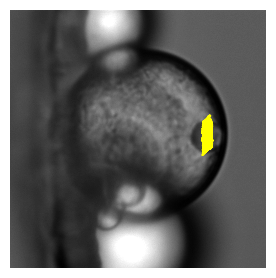

In [364]:
h, w = img.shape
x1, y1 = 0,0
traj.x += x1
traj.y += y1
fig = plt.figure(figsize=(w/100, h/100), dpi=100)
ax = fig.add_axes([0,0,1,1])
ax.imshow(img, cmap="gray")
ax.plot(traj.x, traj.y, color="yellow")
ax.axis("off")

In [324]:
traj

,Unnamed: 0,frame,x,y,particle
0,0,0,NaN,NaN,0
1,1,1,230.000000,162.000000,0
2,2,2,228.516695,165.128915,0
3,3,3,228.671502,163.022372,0
4,4,4,229.569030,163.418781,0
...,...,...,...,...,...
29995,29995,29995,230.973425,193.570893,0
29996,29996,29996,NaN,NaN,0
29997,29997,29997,231.071069,193.503917,0
29998,29998,29998,228.976112,193.864096,0


In [329]:
traj.to_csv(os.path.join(folder, "Trajectory-pxf", "{:03d}.csv".format(i)))

### 1.2 Position PDF

<Axes: >

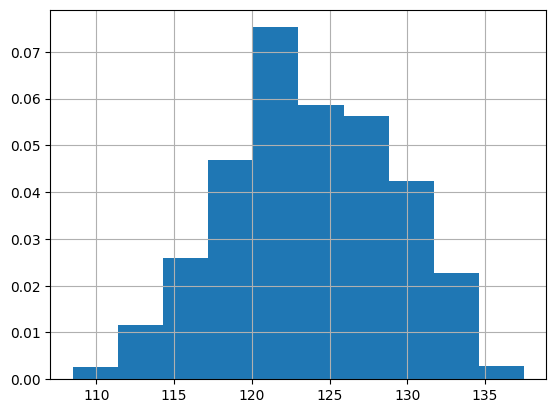

In [28]:
traj.y.hist(density=True)

### 1.3 Anomalous transport - displacement PDF

A key signature of active matter is the enhanced transport, which can be seen by the displacement PDF at various time intervals. Short time and long time should both exhibit Gaussian distribution, due to the stochastic nature of the collision process. Intermediate time interval will be a combination of a Gaussian core and exponential tails, characterized by a well defined length $\lambda$.

#### 1.3.1 PDF vs. $\Delta y$

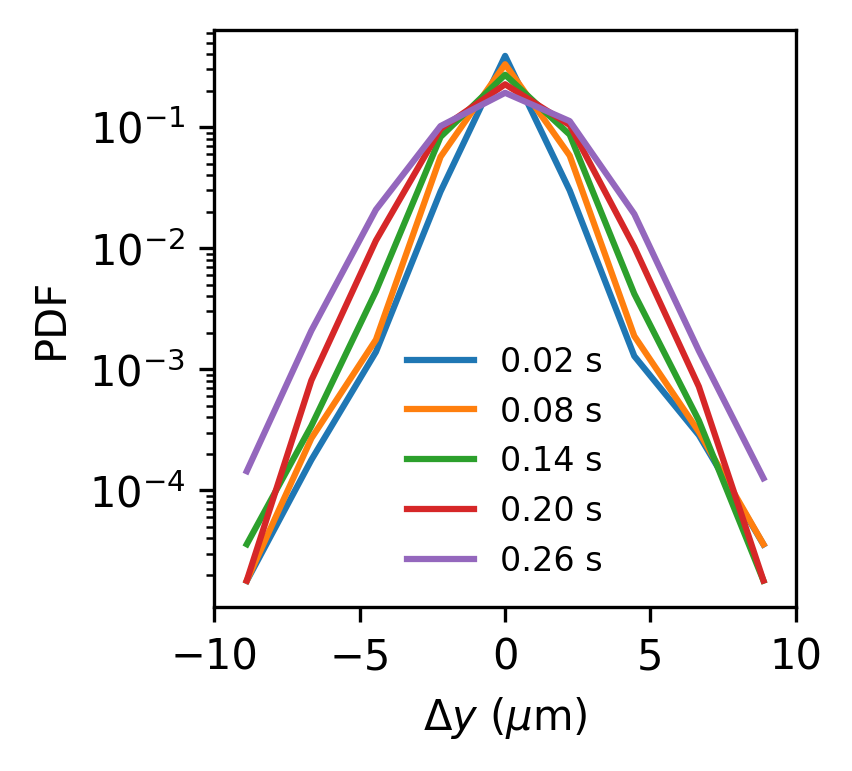

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
for d in range(1,15, 3):
    dy = traj.y.diff(d)
    hist, bin_edges = np.histogram(dy.dropna(), bins=np.linspace(-10, 10, 10), density=True)
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2, hist, label="{:.2f} s".format(d/fps))
ax.set_yscale("log")
ax.set_xlim([-10, 10])
ax.set_xlabel("$\Delta y$ ($\mu$m)")
ax.set_ylabel("PDF")
ax.legend(loc="lower center", fontsize=8, frameon=False)
fig.savefig("pdf-displacement.pdf")

#### 1.3.2 PDF vs. $\Delta y / \Delta t^{1/2}$

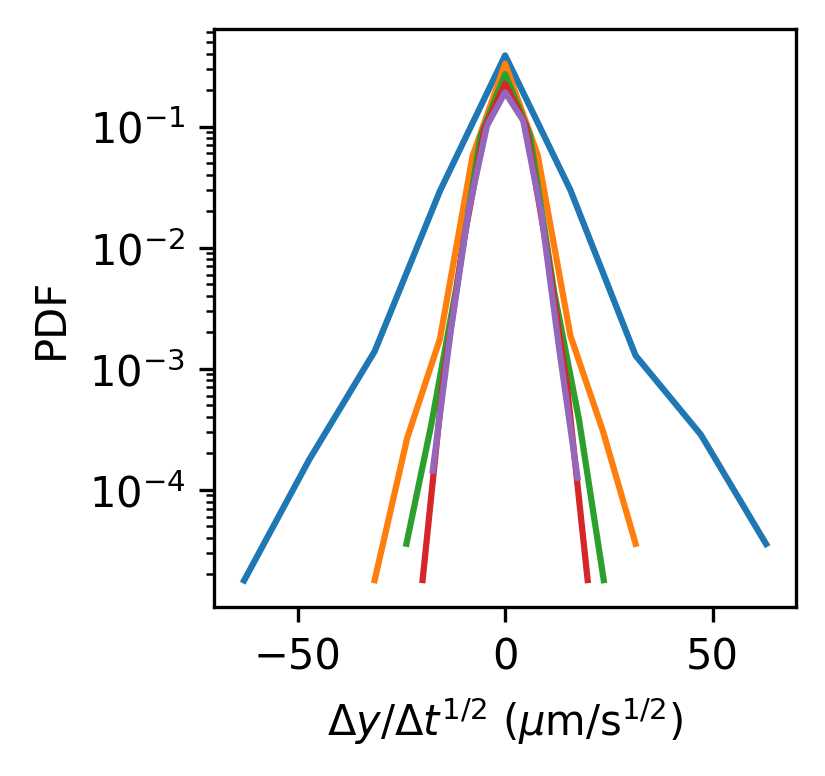

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
for d in range(1, 15, 3):
    dy = traj.y.diff(d)
    hist, bin_edges = np.histogram(dy.dropna(), bins=np.linspace(-10, 10, 10), density=True)
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2/(d/fps)**0.5, hist, label="{:.2f} s".format(d/fps))
ax.set_yscale("log")
ax.set_xlim([-70, 70])
ax.set_xlabel("$\Delta y / \Delta t^{1/2}$ ($\mu$m/s$^{1/2}$)")
ax.set_ylabel("PDF")
# ax.legend(loc="lower center", fontsize=5, frameon=False)
fig.savefig("pdf-displacement-resc.pdf")

### 1.4 Steady state assessment - variance

It is of key importance to verify that the double emulsion systems are in steady state. Here, we use a fixed window to measure the variance of positions over time. In principle, the variance should be proportional to activity, so if the variance deviates from a constant, the data fail the steady state assessment and will be rejected.

In [82]:
DEn = 177
traj_folder = "../Data/traj"
traj = pd.read_csv(os.path.join(traj_folder, "{:02d}.csv".format(DEn)))
fps = log.at[DEn, "FPS"]
mpp = log.at[DEn, "MPP"]
traj = traj.assign(t=traj.frame/fps)

In [90]:
window = 3000
var_list = []
for f in traj.frame:
    if f > len(traj) - window:
        break
    var_list.append(np.nanvar(traj.y.loc[(traj.frame>=f)&(traj.frame<f+window)]))

(0.0, 300.0)

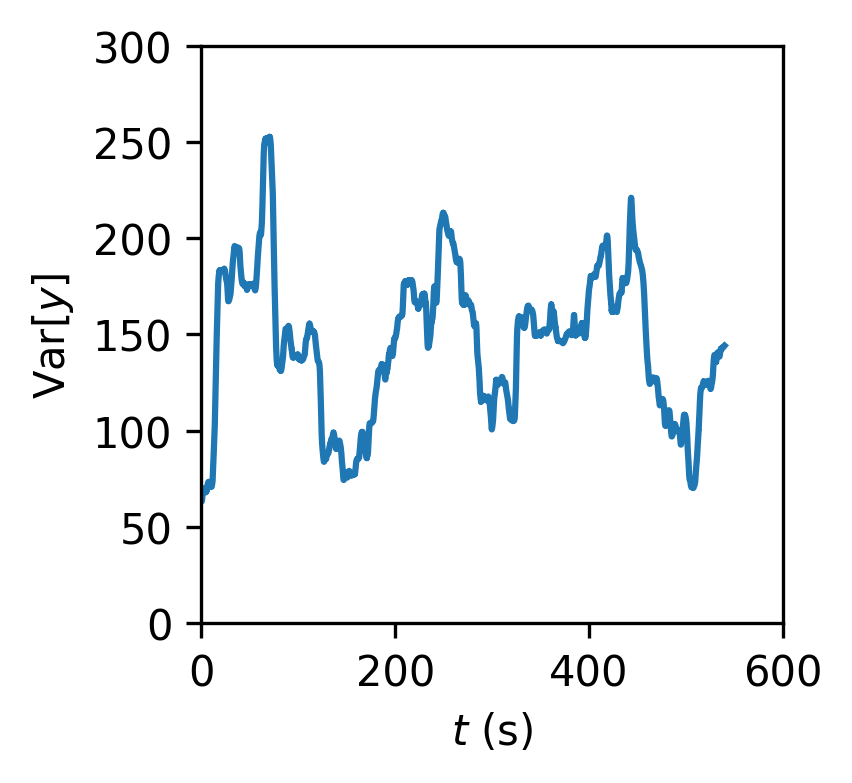

In [92]:
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
ax.plot(np.arange(len(var_list))/fps, var_list)
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("Var$[y]$")
ax.set_xlim([0, 600])
ax.set_ylim([0, 300])

In [58]:
np.nanvar(traj.y[len(traj)//2:])

345.0576936657016

#### 1.4.1 Steadiness - Difference between first half and second half variances

A single number metric of the steadiness is desired. In this context, the best would be the difference of variance between the first half and the second half of the trajectory. For example, if activity drops steadily over time, we will get a big difference between the two. While if the activity fluctuates, the effect will be averaged out. To make the measurement statistically meaningful, we set the variance window at 1000 frames, which typically corresponds to 20 seconds in a video. We start from frames 0\~999, and repeat the variance calculation all the way up to (N-1000)\~N. 

The above algorithm turns out to be slow, since all the steps in a trajectory need to be computed for a variance. Instead, we can only compute two variances for a trajectory, which gives us similar results much faster. 

In [63]:
def steadiness(traj, cols=["y"]):
    """
    Assess the steadiness of a trajectory.
    
    :param traj: trajectory data, a table of (x, y, frame, particle)
    :type traj: pandas.DataFrame
    :return: a number that measures the steadiness, formally defined as 
    
    .. math::
    
       S = 1 - (v_1 - v_2) / v_1
    
    where :math:`v_1`, :math:`v_2` are variance of specified columns in the first and second half, respectively. 
    
    Steadiness is close to 1 if the fluctuation is close to steady state. If activity drops quickly, steadiness is close to 0.
    """
    v1 = np.nanvar(traj[:len(traj)//2][cols])
    v2 = np.nanvar(traj[len(traj)//2:][cols])
    return 1 - (v1 - v2) / v1

In [66]:
S = steadiness(traj)
print(S)

0.8622399355150189


In [69]:
log = pd.read_excel(io="../Data/structured_log_DE.ods", sheet_name="main").set_index("DE#")

In [70]:
for n, i in log.iterrows():
    traj = pd.read_csv(os.path.join(traj_folder, "{:02d}.csv".format(n)))
    S = steadiness(traj)
    log.loc[n, "Steadiness"] = S

Text(0, 0.5, 'count')

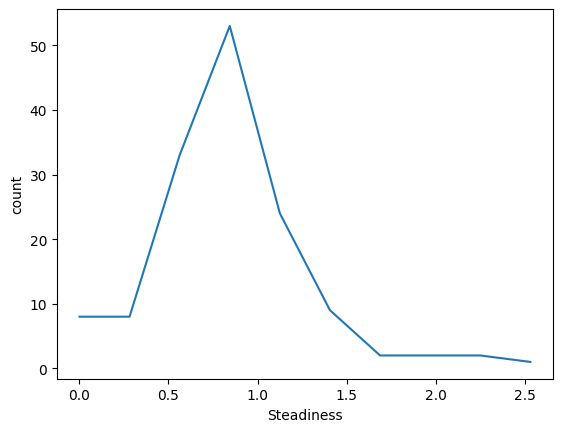

In [73]:
hist, bin_edges = np.histogram(log.Steadiness)
plt.plot(bin_edges[:-1], hist)
plt.xlabel("Steadiness")
plt.ylabel("count")

Note that the definition of steadiness is:
$$
S = 1 - \frac{v_1 - v_2}{v_1}
$$
If $v_2>v_1$, i.e. the activity increases over time, $S>1$. This is considered weird in a biological system, but we do observe quite a few instances. Examine them to get some intuition. This calculation leads to a column "Steadiness" in the main data log. A criterion will be applied to filter out unsteady points, e.g. $S\in [0.8, 1.2]$.

### 1.5 MSD

#### 1.5.1 Compute MSD

In [304]:
# <= 80, hand partial tracking
i = 80
traj = pd.read_csv("/home/zhengyang/GoogleDrive/Research projects/DE/Data/Trajectory-pxf/{:03d}.csv".format(i)).dropna()
traj_l = pd.read_csv("/home/zhengyang/GoogleDrive/Research projects/DE/Data/Trajectory-pxf/{:03d}_l.csv".format(i)).dropna()
traj_l.loc[:, "frame"] /= 50
traj_l.convert_dtypes()

,x,y,frame,particle
0,685,442,0,0
1,682,466,1,0
2,685,450,2,0
3,720,440,3,0
4,694,477,4,0
...,...,...,...,...
605,692,414,605,0
606,693,468,606,0
607,686,476,607,0
608,685,469,608,0


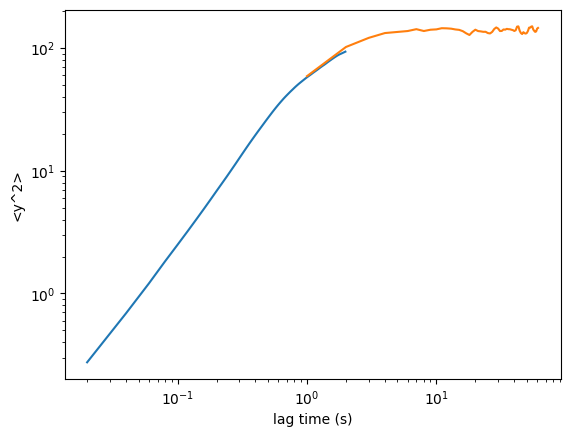

In [305]:
# short
# traj["particle"] = 0
msd = tp.msd(traj, mpp=0.33, fps=50, max_lagtime=len(traj)//10)
plt.plot(msd.lagt, msd["<y^2>"])
msd_l = tp.msd(traj_l, mpp=0.33, fps=1, max_lagtime=len(traj_l)//10)
plt.plot(msd_l.lagt, msd_l["<y^2>"])
plt.loglog()
plt.xlabel("lag time (s)")
plt.ylabel("<y^2>")
save_folder = "/home/zhengyang/GoogleDrive/Research projects/DE/Data/MSD/"
msd.to_csv(os.path.join(save_folder, "{:03d}.csv".format(i)), index=False)
msd_l.to_csv(os.path.join(save_folder, "{:03d}_l.csv".format(i)), index=False)
plt.savefig(os.path.join(save_folder, "{:03d}.jpg".format(i)))

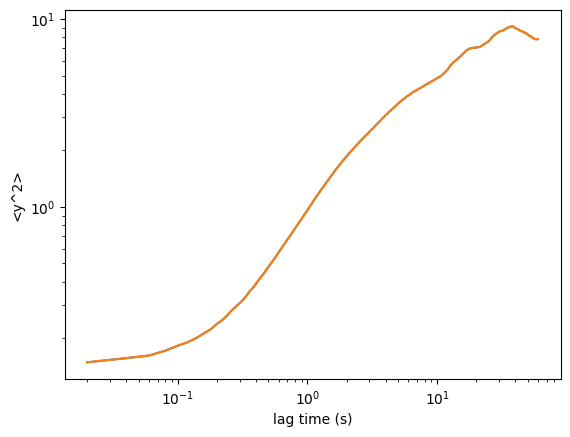

In [386]:
# > 80, full tracking
i = 193
traj = pd.read_csv("/home/zhengyang/GoogleDrive/Research projects/DE/Data/Trajectory-pxf/{:03d}.csv".format(i)).dropna()
msd = tp.msd(traj, mpp=0.33, fps=50, max_lagtime=len(traj)//10)
plt.plot(msd.lagt, msd["<y^2>"])
traj_h = pd.read_csv("/home/zhengyang/GoogleDrive/Research projects/DE/Data/Trajectory-pxf/160-194-handtrack/{:03d}.csv".format(i)).dropna()
msd_h = tp.msd(traj, mpp=0.33, fps=50, max_lagtime=len(traj_h)//10)
plt.plot(msd_h.lagt, msd_h["<y^2>"])

plt.loglog()
plt.xlabel("lag time (s)")
plt.ylabel("<y^2>")

save_folder = "/home/zhengyang/GoogleDrive/Research projects/DE/Data/MSD/"
msd.to_csv(os.path.join(save_folder, "{:03d}.csv".format(i)), index=False)
plt.savefig(os.path.join(save_folder, "{:03d}.jpg".format(i)))


In [383]:
msd

,<x>,<y>,<x^2>,<y^2>,msd,lagt
lagt,,,,,,
1,-0.001100,-0.000377,0.363505,0.041993,0.405498,0.02
2,0.000154,-0.000888,0.377090,0.049637,0.426727,0.04
3,-0.000686,-0.001004,0.382038,0.059447,0.441485,0.06
4,0.000007,-0.000780,0.382469,0.069822,0.452291,0.08
5,0.000320,-0.001141,0.389092,0.080986,0.470078,0.10
...,...,...,...,...,...,...
2891,-0.028312,0.030948,0.436703,5.865453,6.302156,57.82
2892,-0.027388,0.029963,0.436364,5.864240,6.300604,57.84
2893,-0.027715,0.031243,0.434887,5.851345,6.286232,57.86


#### 1.5.2 Detection noise correction

In the past, we have tried to smooth the trajectory data and then compute MSD. While this approach can successfully eliminate the subdiffusive regime in the MSD, it always creates an artificial ballistic regime. Even worse, if the smooth window size is not chosen properly, the artificial time scale can overwrite the time scale from the measurement, making the measurement meaningless.

Hence, we seek a threoretical approach based on reasonable assumptions to minimize the impact of detection noise, while keeping other key features unchanged.

Briefly, if we assume the detection noise of droplets $\sigma$ is additive to the real position
$$
y_i = x_i + \sigma_i,
$$
where $\sigma_i$ is assumed to be random and uncorrelated in time, i.e.
$$
\left< \sigma \right> = 0, \, \left< \sigma_i\sigma_j \right> = A\delta_{ij},
$$
the effect of noise $\sigma$ on the mean square displacement is just a constant offset:
$$
\left< \Delta y^2 \right> = \left<\Delta x^2\right> + 2A
$$

We can evaluate this equation at $\Delta t = 0$, where $\Delta x^2 = 0$ is true, to get the value of $A$:
$$
2A = \left< \Delta y^2 \right>_{\Delta t=0}
$$

For full details, refer to the note [Deal with detection noise](../Notes/2022-07-21_deal-with-detection-noise.pdf) 

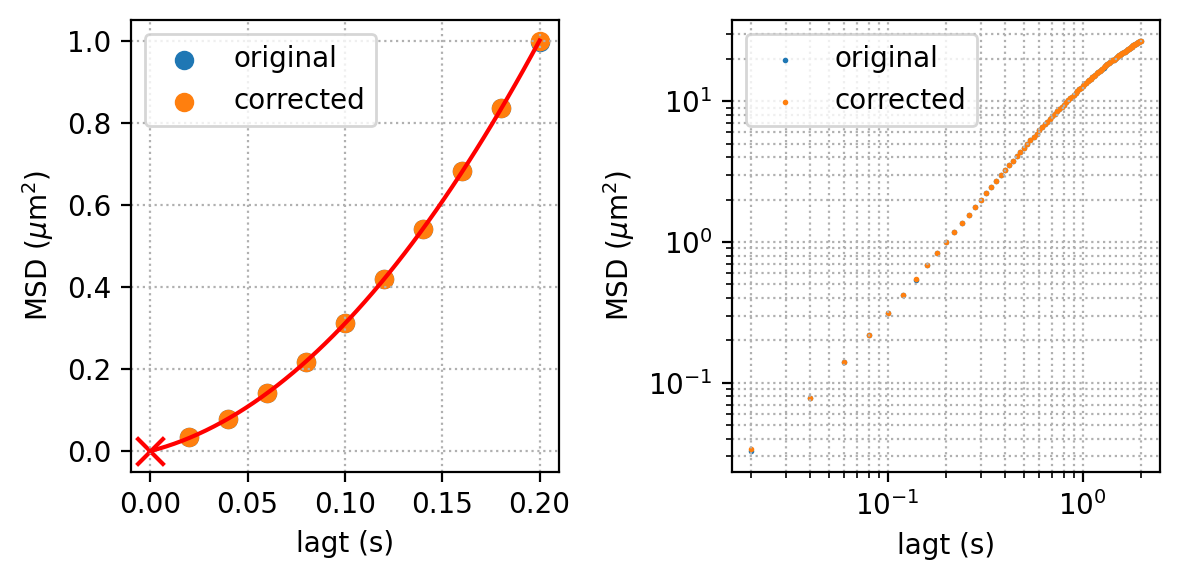

In [120]:
# load data
traj = pd.read_csv("/home/zhengyang/GoogleDrive/Research projects/DE/Data/Trajectory-pxf/024.csv").dropna()

# compute MSD
msd = tp.msd(traj, mpp=0.11, fps=50, max_lagtime=len(traj)//10)
msd = msd.dropna()

# determine offset using extrapolation
x = msd.lagt.iloc[:10]
y = msd["<y^2>"].iloc[:10]
p = np.polyfit(x, y, 2)
xfit = np.linspace(0, 0.2)
yfit = p[0] * xfit ** 2 + p[1] * xfit + p[2]
offset = yfit[0]
# create new_msd
new_msd = msd.copy()
new_msd["<y^2>"] -= offset

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

# Extrapolate offset visualization
ax[0].scatter(x, y, label="original")
ax[0].plot(xfit, yfit, color="red")
ax[0].scatter(xfit[0], yfit[0], marker="x", color="red", s=100)
ax[0].scatter(x, y-offset, label="corrected")
ax[0].set_xlabel("lagt (s)")
ax[0].set_ylabel("MSD ($\mu$m$^2$)")
ax[0].grid(which="both", ls=":")
# ax[0].set_xlim([0, 0.15])
# ax[0].set_ylim([0, 0.1])
ax[0].legend()

# Original and corrected MSD
ax[1].scatter(msd.lagt, msd["<y^2>"], color=bestcolor(0), label="original", s=1)
ax[1].scatter(msd.lagt, msd["<y^2>"] - offset, 
            label="corrected", color=bestcolor(1), s=1)
ax[1].set_xlabel("lagt (s)")
ax[1].set_ylabel("MSD ($\mu$m$^2$)")
ax[1].loglog()
ax[1].grid(which="both", ls=":")
ax[1].legend()

plt.tight_layout()

In [126]:
offset

-0.0008488315246739775

The small offset suggests that the manual tracking is high quality. 

#### 1.5.2 Merge short and long

Automatic tracking is challenging in some videos (mainly < 80). In such cases, we perform hand-tracking on 1000 consecutive frames (20 s) to obtain MSD for short times. Then, we perform hand-tracking on frames 1 second apart to obtain MSD for long times. The full MSD is then obtained by merging two regimes. The two hand-tracking data are stored in separate .csv files. The 1000-frame consecutive tracking is stored as “{:03d}.csv”, while the 1 second apart tracking is stored as “{:03d}_l.csv”, where “l” stands for long.

In this section, we develop the code to compute the full-MSD by merging the short and long.  

#### 1.5.3 Measure the superdiffusion scaling exponent

In [388]:
traj = pd.read_csv("/home/zhengyang/GoogleDrive/Research projects/DE/Data/Trajectory-pxf/024.csv").dropna()
msd = tp.msd(traj, mpp=0.11, fps=50, max_lagtime=len(traj)//10)

In [389]:
x = np.log(new_msd["lagt"])
y = np.log(new_msd["<y^2>"])

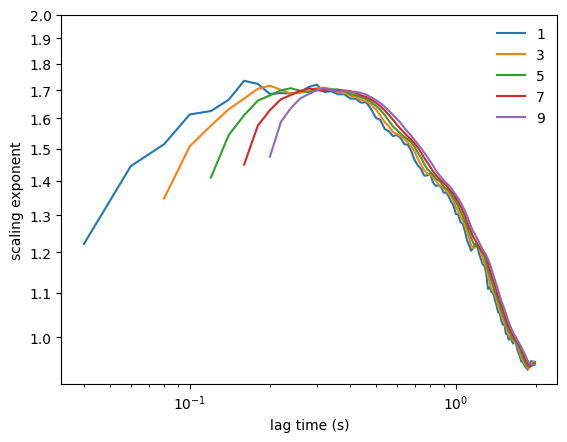

In [392]:
fig, ax = plt.subplots()
for d in range(1, 10, 2):
    ax.plot(msd["lagt"], y.diff(d) / x.diff(d), label=d)
ax.loglog()
ax.legend(frameon=False)
ax.set_xlabel("lag time (s)")
ax.set_ylabel("scaling exponent")
ax.set_yticks([1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


The scaling exponent varies at short times. Varying time interval give qualitatively similar scaling exponent. The plateau value seems to hold for a fraction of second, and may be used for characterizing the superdiffusive behavior. However, a sound justification is still lacking. 

In [396]:
ss_folder = "/home/zhengyang/GoogleDrive/Research projects/DE/Data/Snapshots"
msd_folder = "/home/zhengyang/GoogleDrive/Research projects/DE/Data/MSD"
save_folder = "/home/zhengyang/GoogleDrive/Research projects/DE/Data/Superdiffusion"
l = readdata(ss_folder, "tif")
for num, i in l.iterrows():
    if num < 8:
        continue
    msd = pd.read_csv(os.path.join(msd_folder, i.Name+".csv"))
    msd = msd.loc[msd.lagt<=1]
    x = np.log(msd["lagt"])
    y = np.log(msd["<y^2>"])

    fig, ax = plt.subplots()
    for d in range(1, 10, 2):
        ax.plot(msd["lagt"], y.diff(d) / x.diff(d), label=d)
    ax.loglog()
    ax.legend(frameon=False)
    ax.set_xlabel("lag time (s)")
    ax.set_ylabel("scaling exponent")
    ax.set_yticks([1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    fig.savefig(os.path.join(save_folder, i.Name+".jpg"))
    plt.close()

#### 1.5.4 Measure saturation time 



In [207]:
combine = pd.concat([msd, msd_l.iloc[1:]]).set_index("lagt").sort_values(by="lagt")

[]

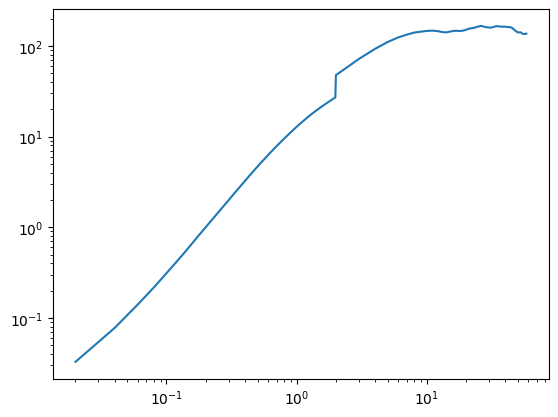

In [208]:
plt.plot(combine.index, combine["<y^2>"])
plt.loglog()

In [219]:
x = np.log(combine.index)
y = np.log(combine["<y^2>"])

In [220]:
def langevin_msd_log(x, DA, tau_star):
    tau = 0.1
    x = np.exp(x)
    dy2 = 2 * DA * tau_star * (1 - np.exp(-x/tau_star) - tau/tau_star*(1-np.exp(-x/tau))) / (1 - (tau/tau_star)**2)
    return np.log(dy2)

t2=12.25 s, DA=7.11 um^2/s


[]

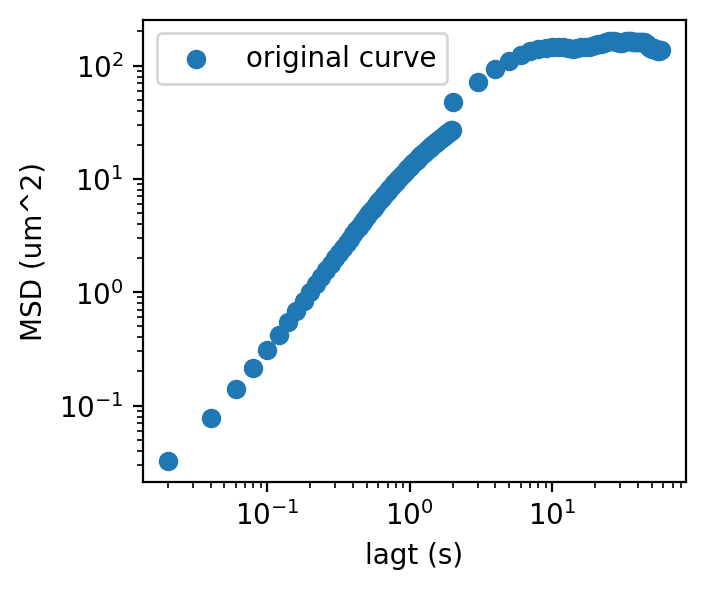

In [221]:
popt, pcov = curve_fit(langevin_msd_log, x, y, p0=[0.5, 2])
print("t2={1:.2f} s, DA={0:.2f} um^2/s".format(popt[0], popt[1]))
plt.figure(figsize=(3.5, 3), dpi=200)
plt.scatter(np.exp(x), np.exp(y), label="original curve")
# plt.plot(np.exp(x), np.exp(langevin_msd_log(x, *popt)), label="fitting", color="red")
plt.legend()
plt.xlabel("lagt (s)")
plt.ylabel("MSD (um^2)")
plt.loglog()

Text(0, 0.5, 'MSD')

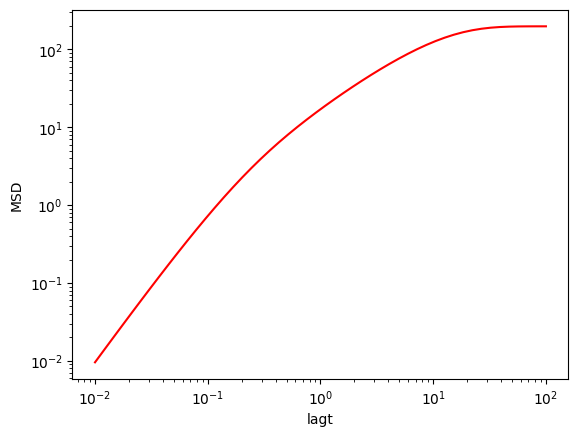

In [217]:
x = np.logspace(-2, 2)
plt.plot(x, np.exp(langevin_msd_log(np.log(x), 10, 10)), label="fitting", color="red")
plt.loglog()
plt.xlabel("lagt")
plt.ylabel("MSD")

## 2 All MSD curves

In [7]:
# There are trajectories that show weird MSD, 
# some of them are due to the very tiny displacement, 
# for others the reason is not yet clear
suspicious_traj = [161, 171, 172, 176, 179, 182, 185, 192, 194, 55]

In [348]:
log1 = log.loc[(log.Steadiness>=0.8)&(log.Steadiness<=1.2)&(log.Fitting!="bad")]

### 2.1 Compute MSD from trajectories

In the repo, we only save the trajectories, as they are considered as the raw data from the videos. In constrast, MSD is a derivative of trajectory, and is different if trajectories are modified. Therefore, we compute MSD every time from the saved trajectories.

In [5]:
# load all the trajectories and compute corresponding MSDs
traj_list, msd_list = {}, {}
for num, i in log1.iterrows():
    nDE = int(num)
    traj_list[nDE] = pd.read_csv(r"..\Data\traj\{:02d}.csv".format(nDE)).fillna(method="ffill").fillna(method="bfill")
    msd_list[nDE] = tp.msd(traj_list[nDE], mpp=i.MPP, fps=i.FPS, max_lagtime=3000).dropna()

In [7]:
folder = r"C:\Users\liuzy\Documents\Github\DE\Data\msd"
for nDE in msd_list:
    msd_list[nDE][["lagt", "<y^2>"]].to_csv(os.path.join(folder, "{:02d}.csv".format(nDE)), index=False)

### 2.2 Plot MSD together

C:\Users\liuzy\AppData\Local\Temp\ipykernel_22156\324135328.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="OD")


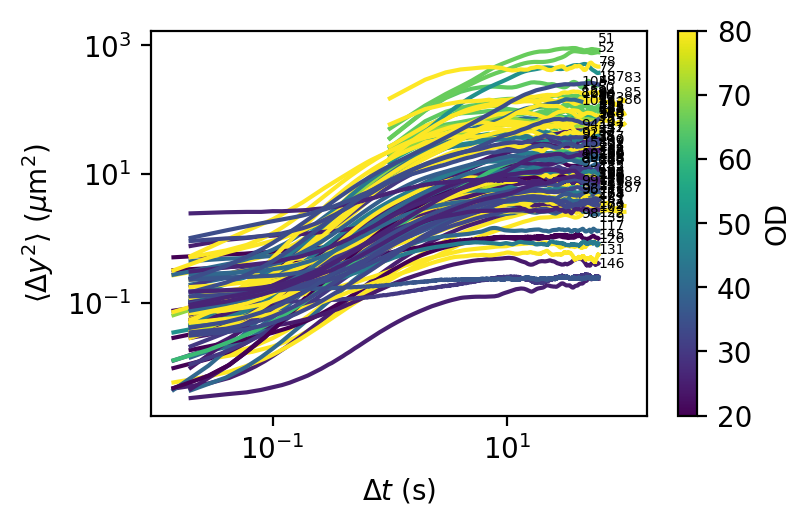

In [6]:
# plot MSD, filter out the suspicious ones
plt.figure(figsize=(4, 2.5), dpi=200)
norm = colors.Normalize(vmin=20, vmax=80)
viridis = plt.cm.get_cmap("viridis")
for num, i in log1.iterrows():
    nDE = int(num)
    plt.plot(msd_list[nDE].lagt, msd_list[nDE]["<y^2>"], color=viridis(norm(i.OD)), label=nDE)
    plt.annotate(nDE, (msd_list[nDE].iloc[-1, 5], msd_list[nDE].iloc[-1, 4]), xycoords="data", fontsize=5)
plt.loglog()
plt.xlabel("$\Delta t$ (s)")
plt.ylabel("$\langle \Delta y^2 \\rangle$ ($\mu$m$^2$)")
sm = cm.ScalarMappable(norm=norm, cmap="viridis")
plt.colorbar(sm, label="OD")

### 2.3 Collapse MSD using fitting parameters $D_A$ and $\tau^*$

Text(0, 0.5, '$\\langle \\Delta y^2 \\rangle / D_A\\tau^*$')

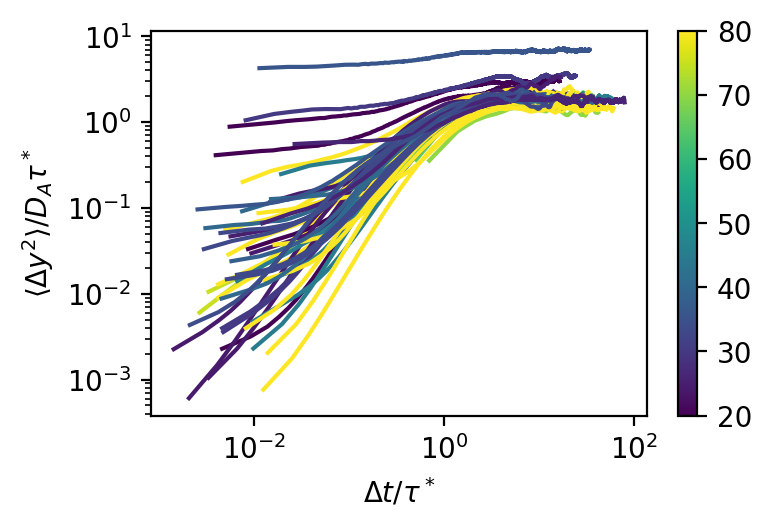

In [182]:
# plot rescaled MSD, collapse
log2 = log1#.dropna(subset=["t2_fit", "DA_fit"])
count = 0
norm = colors.Normalize(vmin=20, vmax=80)
viridis = plt.cm.get_cmap("viridis")
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=200)

sm = cm.ScalarMappable(norm=norm, cmap="viridis")
plt.colorbar(sm, ax=ax)
for num, i in log2.iterrows():
    nDE = int(num)

    t2 = i["t2_fit"]
    DA = i["DA_fit"]
    ax.plot(msd_list[nDE].lagt/t2, msd_list[nDE]["<y^2>"]/DA/t2, 
             color=viridis(norm(i.OD)), label=nDE)
    count += 1
#     if len(msd_list[nDE]) != 0:
#         ax.annotate(nDE, 
#                      [msd_list[nDE].lagt.iloc[0]/t2, msd_list[nDE]["<y^2>"].iloc[0]/DA/t2],
#                      xycoords="data", fontsize=5)    
ax.loglog()
ax.set_xlabel("$\Delta t/\\tau^*$")
ax.set_ylabel("$\langle \Delta y^2 \\rangle / D_A\\tau^*$")

### 2.4 Collapse MSD and correct short time subdiffusive regime

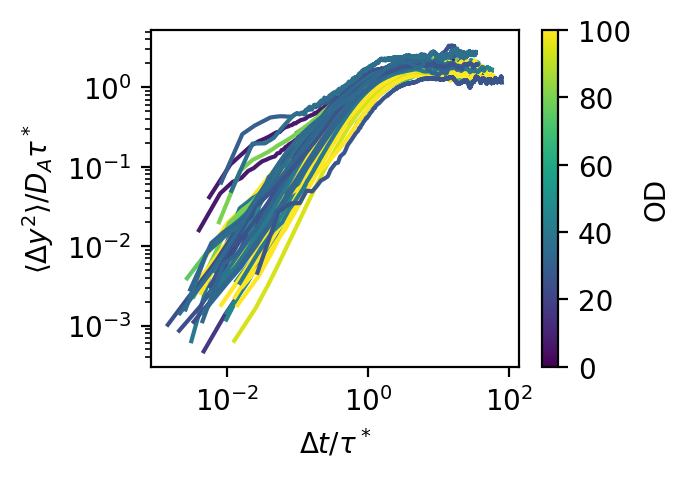

In [362]:
# plot rescaled and corrected MSD, subdiffive regime should disappear
log2 = log1.dropna(subset=["t2_fit", "DA_fit"])
count = 0
norm = colors.Normalize(vmin=0, vmax=100)
viridis = plt.cm.get_cmap("viridis")
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=200)

sm = cm.ScalarMappable(norm=norm, cmap="viridis")
plt.colorbar(sm, ax=ax, label="OD")
for num, i in log2.iterrows():
    nDE = int(num)
    t2 = i["t2_fit"]
    DA = i["DA_fit"]
    msd = msd_list[nDE]
    x = msd.lagt.iloc[:10]
    y = msd["<y^2>"].iloc[:10]
    p = np.polyfit(x, y, 2)
    xfit = np.linspace(0, 0.2)
    yfit = p[0] * xfit ** 2 + p[1] * xfit + p[2]
    offset = yfit[0]
    if nDE <= 80:
        offset = 0
    ax.plot(msd.lagt/t2, (msd["<y^2>"] - offset)/DA/t2, 
             color=viridis(norm(i.OD)), label=nDE)
    count += 1
    # if len(msd_list[nDE]) != 0:
    #     ax.annotate(nDE, 
    #                  [msd_list[nDE].lagt.iloc[0]/t2, msd_list[nDE]["<y^2>"].iloc[0]/DA/t2],
    #                  xycoords="data", fontsize=5)    
ax.loglog()
ax.set_xlabel("$\Delta t/\\tau^*$")
ax.set_ylabel("$\langle \Delta y^2 \\rangle / D_A\\tau^*$")
plt.tight_layout()
fig.savefig("MSD-resc.pdf")

## 3 Fit MSD curves

**unambiguous measurement of $R_\infty$ and $\tau^*$**

Previously, I use hand fitting to roughly measure the saturation time $\tau^*$ and displacement $R_\infty$ of inner droplet MSD. While this technique allow quick data extraction, the measurement is ambiguous and inaccurate for a careful data analysis. Therefore, I now use real curve fitting to extract these values. I use the formula from Maggi et al. 2014 for the first test
$$
\left< \Delta y^2(t) \right> = \frac{2D_A}{\mu k} \frac{1-e^{-\mu kt} - \mu k\tau(1-e^{-t/\tau})}{1-(\mu k\tau)^2}
$$
To make the two time scales more apparent, let $\mu k = 1/\tau^*$ :
$$
\left< \Delta y^2(t) \right> = 2D_A\tau^* \frac{1-e^{-t/\tau^*} - \tau/\tau^*(1-e^{-t/\tau})}{1-(\tau/\tau^*)^2}
$$

### 3.1 Preprocessing of MSD data

In the past, we have tried to smooth the trajectory data and then compute MSD. While this approach can successfully eliminate the subdiffusive regime in the MSD, it always creates an artificial ballistic regime. Even worse, if the smooth window size is not chosen properly, the artificial time scale can overwrite the time scale from the measurement, making the measurement meaningless.

Hence, we seek a threoretical approach based on reasonable assumptions to minimize the impact of detection noise, while keeping other key features unchanged.

Briefly, if we assume the detection noise of droplets $\sigma$ is additive to the real position
$$
y_i = x_i + \sigma_i,
$$
where $\sigma_i$ is assumed to be random and uncorrelated in time, i.e.
$$
\left< \sigma \right> = 0, \, \left< \sigma_i\sigma_j \right> = A\delta_{ij},
$$
the effect of noise $\sigma$ on the mean square displacement is just a constant offset:
$$
\left< \Delta y^2 \right> = \left<\Delta x^2\right> + 2A
$$

We can evaluate this equation at $\Delta t = 0$, where $\Delta x^2 = 0$ is true, to get the value of $A$:
$$
2A = \left< \Delta y^2 \right>_{\Delta t=0}
$$

For full details, refer to the note [Deal with detection noise](../Notes/2022-07-21_deal-with-detection-noise.pdf) 

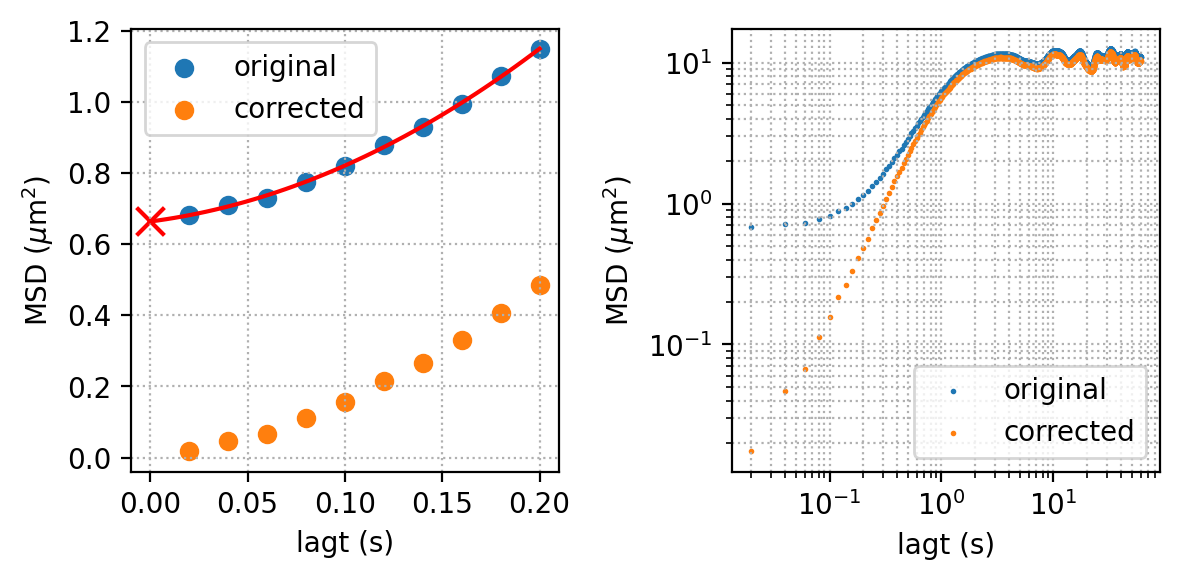

In [4]:
# load data
i = 171
logi = log.loc[i]
traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i))).dropna()
# compute MSD
msd = tp.msd(traj, mpp=float(logi.MPP), fps=float(logi.FPS), max_lagtime=3000)
msd = msd.dropna()
# determine offset using extrapolation
x = msd.lagt.iloc[:10]
y = msd["<y^2>"].iloc[:10]
p = np.polyfit(x, y, 2)
xfit = np.linspace(0, 0.2)
yfit = p[0] * xfit ** 2 + p[1] * xfit + p[2]
offset = yfit[0]
# create new_msd
new_msd = msd.copy()
new_msd["<y^2>"] -= offset

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

# Extrapolate offset visualization
ax[0].scatter(x, y, label="original")
ax[0].plot(xfit, yfit, color="red")
ax[0].scatter(xfit[0], yfit[0], marker="x", color="red", s=100)
ax[0].scatter(x, y-offset, label="corrected")
ax[0].set_xlabel("lagt (s)")
ax[0].set_ylabel("MSD ($\mu$m$^2$)")
ax[0].grid(which="both", ls=":")
# ax[0].set_xlim([0, 0.15])
# ax[0].set_ylim([0, 0.1])
ax[0].legend()

# Original and corrected MSD
ax[1].scatter(msd.lagt, msd["<y^2>"], color=bestcolor(0), label="original", s=1)
ax[1].scatter(msd.lagt, msd["<y^2>"] - offset, 
            label="corrected", color=bestcolor(1), s=1)
ax[1].set_xlabel("lagt (s)")
ax[1].set_ylabel("MSD ($\mu$m$^2$)")
ax[1].loglog()
ax[1].grid(which="both", ls=":")
ax[1].legend()

plt.tight_layout()

#### Aside: artificial traj with short time noise to reproduce the subdiffusive regime at short times

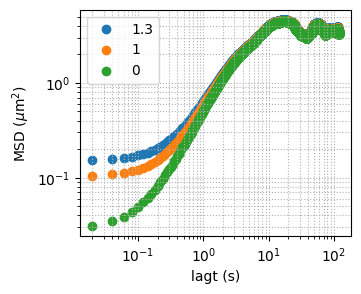

In [459]:
i = 175
logi = log.loc[i]
traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i))).dropna()
# traj.y = gaussian_filter1d(traj.y, sigma=3/4)

plt.figure(figsize=(3.5, 3), dpi=100)
for noise in [1.3, 1, 0]:
    t = traj.copy()
    t.x += (2 * np.random.rand(len(t)) - 1) * noise
    t.y += (2 * np.random.rand(len(t)) - 1) * noise
    msd = tp.msd(t, mpp=float(logi.MPP), fps=float(logi.FPS), max_lagtime=6000)
    msd = msd.dropna()
    plt.scatter(msd.lagt, msd["<y^2>"], label=noise)

plt.xlabel("lagt (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.loglog()
plt.grid(which="both", ls=":")
plt.legend()

### 3.2 Direct fitting

Let us try first to directly fit the MSD data using the 3-parameter Langevin model
$$
\left< \Delta y^2(t) \right> = 2D_A\tau^* \frac{1-e^{-t/\tau^*} - \tau/\tau^*(1-e^{-t/\tau})}{1-(\tau/\tau^*)^2}
$$

In [68]:
def msd_model(lagt, DA, tau, tau_star):
    """This is the mean square displacement predicted by the langevin model with exponentially correlated active noise.
    """
    dy2 = 2*DA*tau_star * (1-np.exp(-lagt/tau_star) - tau/tau_star*(1-np.exp(-lagt/tau))) / (1 - (tau/tau_star)**2)
    return dy2

t1=3.26 s, t2=3.26 s, DA=133.53 um^2/s


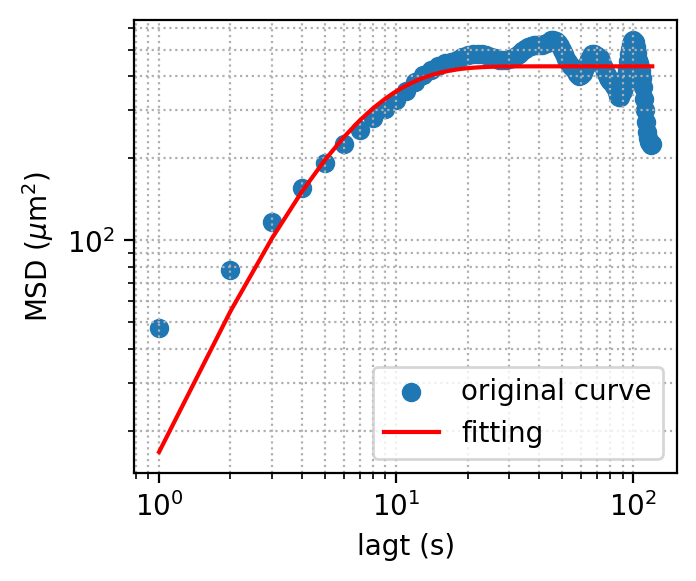

In [463]:
popt, pcov = curve_fit(msd_model, new_msd.lagt, new_msd["<y^2>"], p0=[100, 0.1, 1])
print("t1={0:.2f} s, t2={1:.2f} s, DA={2:.2f} um^2/s".format(popt[1], popt[2], popt[0]))
plt.figure(figsize=(3.5, 3), dpi=200)
plt.scatter(new_msd.lagt, new_msd["<y^2>"], label="original curve")
plt.plot(msd.lagt, msd_model(msd.lagt, *popt), label="fitting", color="red")
plt.legend()
plt.xlabel("lagt (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.loglog()
plt.grid(which="both", ls=":")

### 3.3 Fit the log data

The MSD data span more than 3 orders of magnitude. When we fit directly by minimizing the least square, the small MSD regime does not fit well. This is because at small scale, even if the fitting deviates from data by 100%, the absolute square error is nothing compared to a small deviation at large scales. To make both small and large scale fitting important, we take a log of the MSD data to make the numbers to be fitted on the same order of magnitude. 

In [63]:
# try to fit log data
def msd_model_log(lagt, DA, tau, tau_star):
    """This is the mean square displacement predicted by the langevin model with exponentially correlated active noise.
    """
    dy2 = 2*DA*tau_star * (1-np.exp(-lagt/tau_star) - tau/tau_star*(1-np.exp(-lagt/tau))) / (1 - (tau/tau_star)**2)
    return np.log(dy2)

t1=0.55 s, t2=0.55 s, DA=19.03 um^2/s


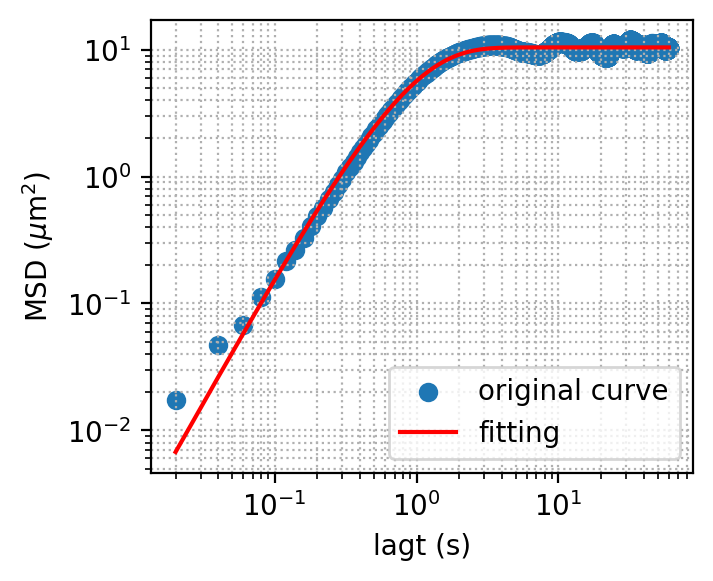

In [42]:
popt, pcov = curve_fit(msd_model_log, new_msd.lagt, np.log(new_msd["<y^2>"]), 
                       p0=[100, 0.1, 1])
print("t1={0:.2f} s, t2={1:.2f} s, DA={2:.2f} um^2/s".format(popt[1], popt[2], popt[0]))
plt.figure(figsize=(3.5, 3), dpi=200)
plt.scatter(new_msd.lagt, new_msd["<y^2>"], label="original curve")
plt.plot(msd.lagt, msd_model(msd.lagt, *popt), label="fitting", color="red")
plt.legend()
plt.xlabel("lagt (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.loglog()
plt.grid(which="both", ls=":")

### 3.4 Simple 2-parameter model, fix $\tau=0.15$ s (deprecated)

$\tau = 0.15$ s is a characteristic time scale of bacterial dynamics, estimated from the length of bacteria $l_b\approx 3$ $\mu$m and the swimming speed of bacteria $v_b\approx 20$ $\mu$m/s:
$$
\tau = \frac{l_b}{v_b} = 0.15 \:\text{s}
$$
We also assume that $t\gg\tau$, so that $e^{-t/\tau}\to 0$. This leads to a simplified model with only two fitting parameters $D_A$ and $\tau^*$: (keeping the $e^{-t/\tau}$ term leads to difficulty in fitting)
$$
\left< \Delta y^2(t) \right> = 2D_A\tau^* \frac{1-e^{-t/\tau^*} - \tau/\tau^*}{1-(\tau/\tau^*)^2}
$$

In [137]:
def msd_model_simp(lagt, DA, tau_star):
    """This is the mean square displacement predicted by the langevin model with exponentially correlated active noise.
    """
    tau = 0.15
    dy2 = 2*DA*tau_star * (1-np.exp(-lagt/tau_star) - tau/tau_star) / (1 - (tau/tau_star)**2)
    return dy2

t2=3.56 s, DA=0.53 um^2/s


[]

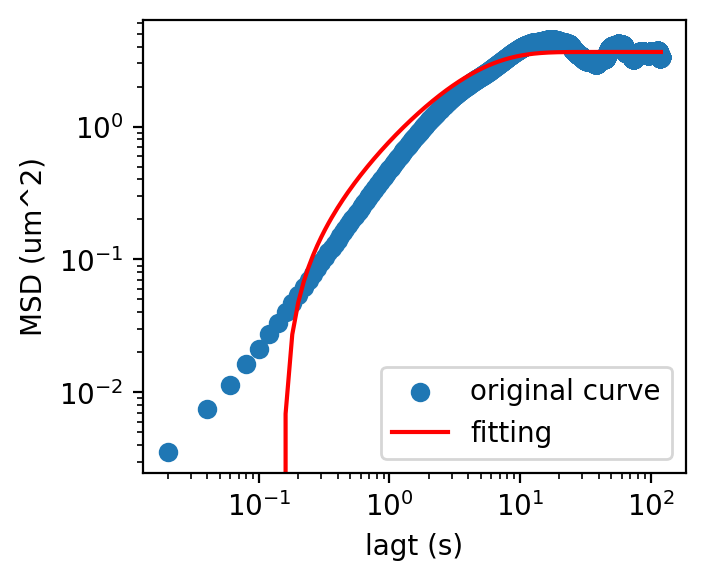

In [225]:
popt, pcov = curve_fit(msd_model_simp, new_msd.lagt, new_msd["<y^2>"], p0=[1, 5])
print("t2={1:.2f} s, DA={0:.2f} um^2/s".format(popt[0], popt[1]))
plt.figure(figsize=(3.5, 3), dpi=200)
plt.scatter(new_msd.lagt, new_msd["<y^2>"], label="original curve")
plt.plot(msd.lagt, msd_model_simp(msd.lagt, *popt), label="fitting", color="red")
plt.legend()
plt.xlabel("lagt (s)")
plt.ylabel("MSD (um^2)")
plt.loglog()

The fitting works pretty well for the long time limit. However, in the short time regime, due to our approximation, the fitting goes off. Now that we are able to get full trajectories, we deprecate this simple model fitting and switch to original model fitting.

### 3.5 Fit all the MSD data and generate MSD fitting repo

Using the reduced model, we fit all the MSD curves and extract more accurate and unambiguous $D_A$ and $\tau^*$. To be able to check the fitting quality later, I save all the fitting plots in the MSD repo so I can come back at any time. 

<font color="red">The block below plots MSD fittings and save results as pictures in "Pictures" folder!</font>

In [62]:
log1

,Date,Video#,MPP,FPS,OD,D,D_err,d,d_err,Easy to analyze?,...,t1_fit,t2_fit,DA_fit,(D-d)/d,DA/OD,c,number of bacteria,mean velocity (1s),mean velocity middle,mean velocity end
DE#,,,,,,,,,,,,,,,,,,,,,
81,NaT,experimento201020_DE_60x_od61_70fps_exp_002,0.11,70.0,61,38.3,NaN,12.1,NaN,NaN,...,NaN,8.048422,0.015487,2.165289,0.000254,0.252369,1389.567179,NaN,NaN,NaN
82,NaT,experimento201020_DE_60x_od83_70fps_exp_4_002,0.11,70.0,83,46.3,NaN,7.9,NaN,NaN,...,NaN,3.795602,0.106920,4.860759,0.001288,0.076638,3431.837488,NaN,NaN,NaN
83,NaT,experimentoDE_7_11_19_30fps_60x_exp2_1003,0.11,30.0,94,57.1,NaN,11.4,NaN,NaN,...,NaN,3.441970,0.247953,4.008772,0.002638,0.096355,7268.329443,NaN,NaN,NaN
84,NaT,experimentoDE_7_11_19_30fps_60x_exp3003,0.11,30.0,170,45.9,NaN,12.0,NaN,NaN,...,NaN,6.878155,0.001884,2.825000,0.000011,0.117170,6759.657369,NaN,NaN,NaN
85,NaT,experimentoDE_15_10_19_30fps_exp2_60x003,0.11,30.0,100,57.3,NaN,12.4,NaN,NaN,...,NaN,3.704945,0.149033,3.620968,0.001490,0.021144,7796.657387,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,NaT,experimentoexp_od125_60x_50fps_1003,0.11,50.0,125,90.8,NaN,42.6,NaN,NaN,...,NaN,1.481641,0.038977,1.131455,0.000312,0.065855,35131.604051,NaN,NaN,NaN
157,NaT,experimentoVideos_2020DE_60x_70fps_OD_17_exp002,0.11,70.0,17,40.4,NaN,13.4,NaN,NaN,...,NaN,2.970658,0.018288,2.014925,0.001076,0.027666,452.186677,NaN,NaN,NaN
158,NaT,experimentoVideos_2020201020_DE_60x_od61_70fps...,0.11,70.0,61,38.3,NaN,12.1,NaN,NaN,...,NaN,8.048422,0.015487,2.165289,0.000254,0.050780,1389.567179,NaN,NaN,NaN


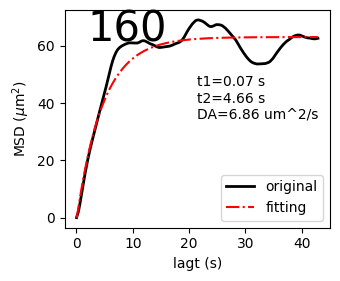

In [157]:
traj_folder = os.path.join(data_folder, "traj")
fig_folder = r"C:\Users\liuzy\Pictures"
# log1 = log.loc[log.Comment!="Chile"]
count = 0
DE_list = [] # DE# list
DA_list = [] # container for fitted D_A values
tau_list = [] # container for fitted tau values
for num, i in log1.iterrows():
    nDE = int(num)
    # filtering conditions
    # if nDE <= 160 or nDE in suspicious_traj:
    #     continue
    if os.path.exists(os.path.join(traj_folder, "{:02d}.csv".format(num))) == False:
        continue
#     traj = pd.read_csv(os.path.join(traj_folder, "{:02d}.csv".format(i["DE#"])))
#     msd = tp.msd(traj, mpp=i.MPP, fps=i.FPS, max_lagtime=traj.frame.max()//5)
#     msd = msd.dropna()    
    msd = msd_list[nDE]
    
    # obtain offset
    x = msd.lagt.iloc[:10]
    y = msd["<y^2>"].iloc[:10]
    p = np.polyfit(x, y, 2)
    xfit = np.linspace(0, 0.2)
    yfit = p[0] * xfit ** 2 + p[1] * xfit + p[2]
    offset = yfit[0]
    try:
        popt, pcov = curve_fit(msd_model_log, msd.lagt, np.log(msd["<y^2>"]-offset), p0=[4, .01, 5])
    except:
        continue
    fig, ax = plt.subplots(figsize=(3.5, 3), dpi=100)
    ax.plot(msd.lagt, msd["<y^2>"]-offset, color="black", lw=2, label="original")
    ax.plot(msd.lagt, msd_model(msd.lagt, *popt), color="red", ls="-.",label="fitting")
    ax.legend(loc="lower right")
    ax.set_xlabel("lagt (s)")
    ax.set_ylabel("MSD ($\mu$m$^2$)")
    ax.annotate("{:d}".format(num), (.25, .8), xycoords="figure fraction", fontsize=30)
    ax.annotate("t1={0:.2f} s\nt2={1:.2f} s\nDA={2:.2f} um^2/s".format(popt[1], popt[2], popt[0]), 
                (.5, .5), xycoords="axes fraction", fontsize=10)
    # ax.loglog()
    plt.tight_layout()
    plt.pause(0.01)
    fig.savefig(os.path.join(fig_folder, "lin{:d}.jpg".format(num)))
    clear_output(wait=True)
    plt.close()
    count += 1
    if count > 10000:
        break

### 3.6 Weighted fitting

The small time region has sparser data, so even if I take a log to the whole data and fit, the small time region still play less role than the larger time region, leading to bad fitting quality at small times, and unprecise determination of $t_1$. To fix this problem, we introduce weighted fitting to put more weight on the small times. 

Since the density of points gets larger exponentially, we put weight as an exponential decay:
$$
w(t) = e^{-t/\tau_c}
$$

In `scipy.curve_fit()`, weight is not set directly. The uncertainty `sigma` is similar to the role of weight. It allows me to specify the uncertainty of each data point. Data point with smaller uncertainty is trusted more, so in effect more weight is put on it. Therefore, we set the uncertainty `sigma` as the inverse of our intended weight $w(t)$:
$$
\sigma = 1 - w(t) = 1 - e^{-t/\tau_c}
$$

In [433]:
# load data
i = 175
logi = log.loc[i]
traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i))).dropna()
# compute MSD
msd = tp.msd(traj, mpp=float(logi.MPP), fps=float(logi.FPS), max_lagtime=6000)
msd = msd.dropna()
# determine offset using extrapolation
x = msd.lagt.iloc[:10]
y = msd["<y^2>"].iloc[:10]
p = np.polyfit(x, y, 2)
xfit = np.linspace(0, 0.2)
yfit = p[0] * xfit ** 2 + p[1] * xfit + p[2]
offset = yfit[0]
# create new_msd
new_msd = msd.copy()
new_msd["<y^2>"] -= offset

In [434]:
# sigma = 2*np.ones(len(new_msd))
# sigma[:20] = 1
sigma = 1 - np.exp(-new_msd.lagt)

C:\Users\liuzy\Miniconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


t1=0.29 s, t2=4.04 s, DA=0.48 um^2/s
t1=0.02 s, t2=9.59 s, DA=0.19 um^2/s


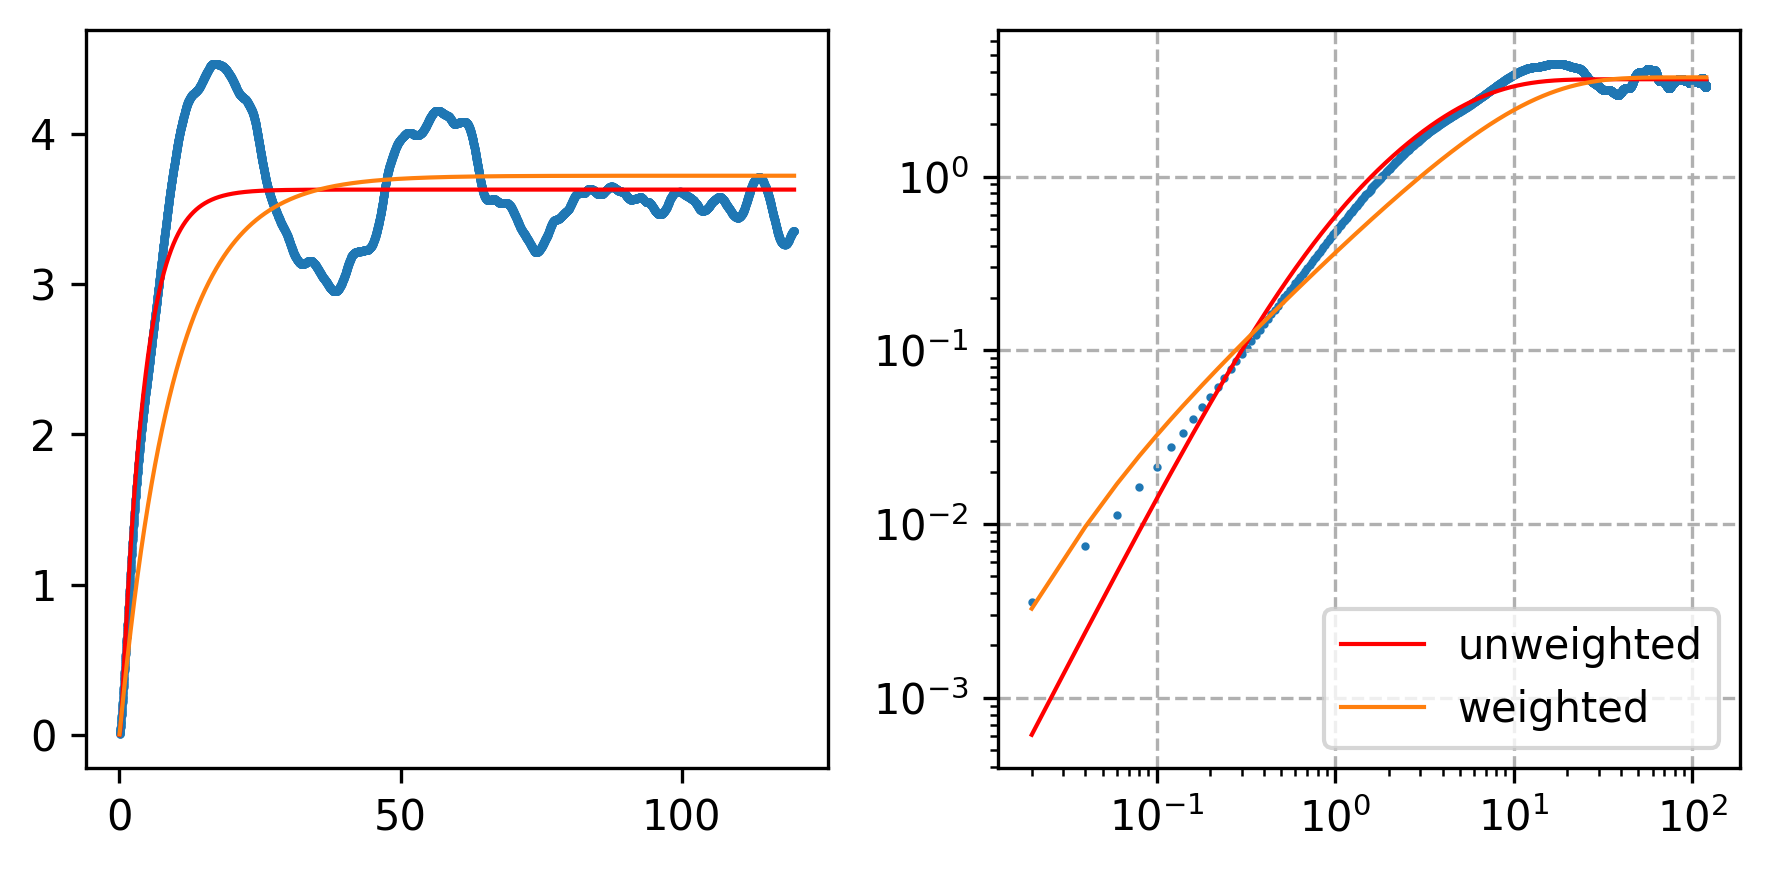

In [435]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
ax[0].scatter(new_msd.lagt, new_msd["<y^2>"], s=1)
ax[1].scatter(new_msd.lagt, new_msd["<y^2>"], s=1)
popt, pcov = curve_fit(msd_model_log, new_msd.lagt, np.log(new_msd["<y^2>"]), p0=[1, 0.01, 4])
print("t1={0:.2f} s, t2={1:.2f} s, DA={2:.2f} um^2/s".format(popt[1], popt[2], popt[0]))
ax[0].plot(new_msd.lagt, msd_model(new_msd.lagt, *popt), color="red", lw=1)
ax[1].plot(new_msd.lagt, msd_model(new_msd.lagt, *popt), color="red", label="unweighted", lw=1)
popt, pcov = curve_fit(msd_model_log, new_msd.lagt, np.log(new_msd["<y^2>"]), p0=popt, sigma=sigma)
ax[0].plot(new_msd.lagt, msd_model(new_msd.lagt, *popt), color=bestcolor(1), lw=1)
ax[1].plot(new_msd.lagt, msd_model(new_msd.lagt, *popt), color=bestcolor(1), label="weighted", lw=1)
ax[1].loglog()
ax[1].legend()
ax[1].grid(ls="--")
print("t1={0:.2f} s, t2={1:.2f} s, DA={2:.2f} um^2/s".format(popt[1], popt[2], popt[0]))

plt.tight_layout()

 The plots above compares unweighted fitting and weighted fitting. From the linear plot (left), we can see that the weighted fitting does not capture the crossover to saturation accurately. From the loglog plot (right), we can see that the weighted fitting captures the first several data points better. Taken together, the weighted fitting does not improve the most important aspect of the fitting, which is to capture the transition time accurately. Therefore, we stay on the unweighted fitting, and ignore the deviation in the small time limit.

### 3.7 Offset reduced memory model

$$
\left< \Delta y^2 \right>  = 2 D_A \tau^* \frac{ 1 - e^{-t/\tau^*} - \tau/\tau^*(1-e^{-t/\tau})}{1 - (\tau/\tau^*)^2} + c
$$

Here, the offset accounts for the droplet detection error, which in theory will offset the MSD by a small distance. For a good detection method, this offset should be less than 1 px, corresponding to 0.33 or 0.11 um (0.1~0.01 um^2 for MSD) depending on the lens used. Larger values are found in real data, and these data need careful inspection. 

In [371]:
def offset_reduced_memory_model(x, DA, tau, tau_star, offset):
    dy2 = 2 * DA * tau_star * (1 - np.exp(-x/tau_star) - tau/tau_star*(1-np.exp(-x/tau))) / (1 - (tau/tau_star)**2) + offset
    return dy2

In [368]:
def offset_reduced_memory_model_log(x, DA, tau, tau_star, offset):
    dy2 = 2 * DA * tau_star * (1 - np.exp(-x/tau_star) - tau/tau_star*(1-np.exp(-x/tau))) / (1 - (tau/tau_star)**2) + offset
    return np.log(dy2)

In [364]:
folder = r"../Data/traj/"

In [365]:
n = 166
traj = pd.read_csv(os.path.join(folder, "{:2d}.csv".format(n))).fillna(method="ffill").fillna(method="bfill")
fps = log.loc[n].FPS
mpp = log.loc[n].MPP
print("DE#{:2d}".format(n))

DE#166


In [366]:
msd = tp.msd(traj, fps=fps, mpp=mpp, max_lagtime=traj.frame.max()//10).dropna()

In [369]:
x = msd.lagt
y = msd["<y^2>"]
popt, pcov = curve_fit(offset_reduced_memory_model_log, x, np.log(y), p0=[10, .1, 5, 0], 
                       bounds=([-np.inf, -np.inf, -np.inf, 0], [np.inf, 1, np.inf, 3]))

C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

invalid value encountered in log



In [1369]:
popt

array([1.24716921e-01, 1.04571442e-01, 9.59504832e+00, 6.27292304e-03])

Text(0, 1, '#166')

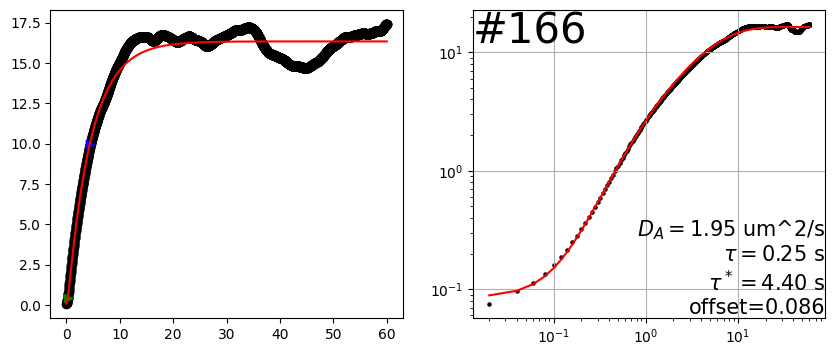

In [372]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(x, y, color="black")
ax[0].plot(x, offset_reduced_memory_model(x, *popt), color="red")
ax[0].scatter(popt[1], offset_reduced_memory_model(popt[1], *popt), color="green", marker=">")
ax[0].scatter(popt[2], offset_reduced_memory_model(popt[2], *popt), color="blue", marker=">")

ax[1].scatter(x, y, color="black", s=5)
ax[1].plot(x, offset_reduced_memory_model(x, *popt), color="red")

# ax[1].scatter(popt[1], offset_reduced_memory_model(popt[1], *popt), color="green", marker=">", s=100)
# ax[1].scatter(popt[2], offset_reduced_memory_model(popt[2], *popt), color="blue", marker=">", s=100)
ax[1].annotate("$D_A=${0:.2f} um^2/s\n$\\tau=${1:.2f} s\n$\\tau^*=${2:.2f} s\noffset={3:.3f}".format(popt[0], popt[1], popt[2], popt[3]), 
               [1, 0], horizontalalignment="right", verticalalignment="bottom", xycoords="axes fraction",
               fontsize=15)
ax[1].loglog()
ax[1].grid()
ax[1].annotate("#{:2d}".format(n), (0, 1), verticalalignment="top", fontsize=30, xycoords="axes fraction")

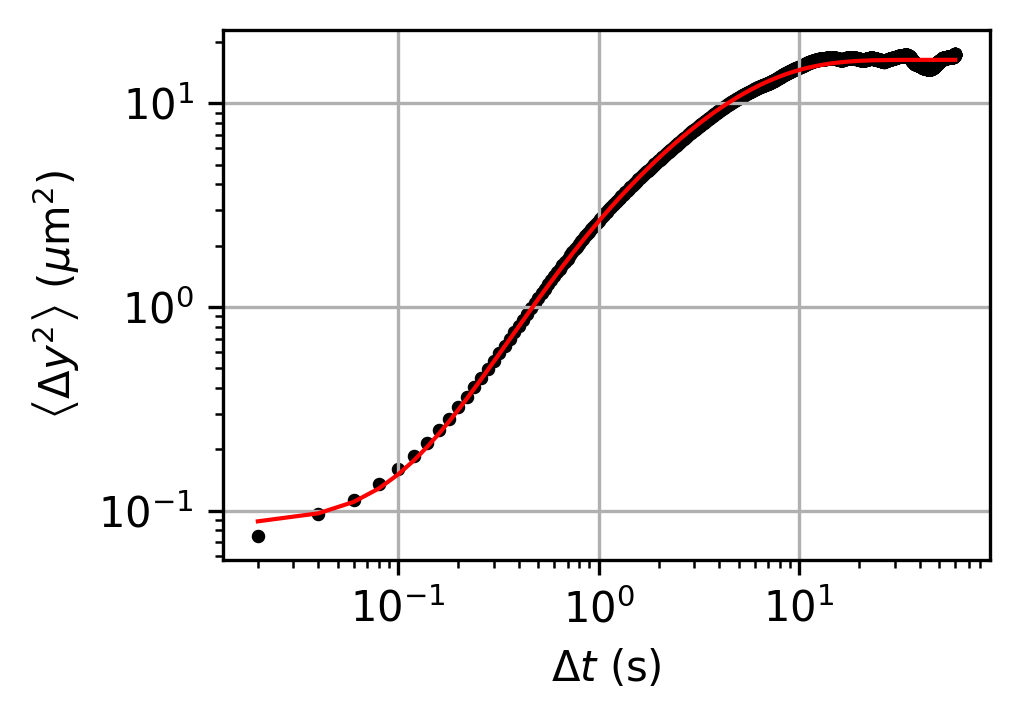

In [376]:
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300)
ax.scatter(x, y, color="black", s=5)
ax.plot(x, offset_reduced_memory_model(x, *popt), color="red", lw=1)
ax.loglog()
ax.grid()
ax.set_xlabel("$\Delta t$ (s)")
ax.set_ylabel("$\left< \Delta y^2 \\right>$ ($\mu$m$^2$)")

plt.tight_layout()
fig.savefig("fit-MSD.pdf")

### 3.8 $v_b^2$ notation fitting

Cristian has a new model to fit data, which essentially is the same as Maggi's model, but with a different set of notations:

$$
\left< \Delta x^2 \right> = \frac{2v_b^2}{\frac{1}{\tilde\tau}+\frac{1}{\tau}}\left[  \frac{1-e^{-\frac{2}{\tilde\tau}t}}{\frac{2}{\tilde\tau}} - \frac{e^{-(\frac{1}{\tilde\tau}+\frac{1}{\tau})t} - e^{-\frac{2t}{\tilde\tau}}}{\frac{1}{\tilde\tau} - \frac{1}{\tau}} \right].
$$

I'm going to fit all the data to this model.

Here we fit the data in two regimes, separated by the slope of log-log curve $\alpha=1.7$. The slope is formally defined as 

$$
\alpha(t) = \frac{d\log{\text{MSD}}}{d\log{t}}.
$$ 

The short time regime is fit to
$$
\left< \Delta x^2 \right> = v_b^2 \tau [t-\tau(1-e^{-t/\tau})],
$$
and $v_b$, $\tau$ will be extracted from this fit. Then with these values fixed, we fit the whole curve with the full solution (with only $\tilde\tau$ as free parameter).

#### 3.8.0 What does the short time model look like?

$v_b = 1$ um/s, $\tau=0.15$ s, $t\in[0, 1]$.

Text(0, 0.5, '$\\left< \\Delta y^2\\right>$')

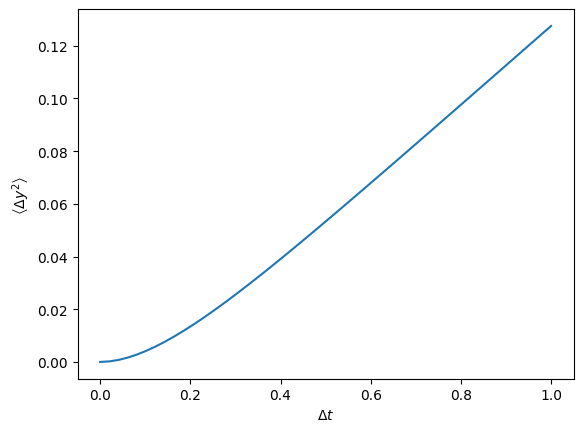

In [72]:
vb = 1
tau = 0.15
t = np.linspace(0, 1)
x2 = vb ** 2 * tau * (t - tau * (1 - np.exp(-t/tau)))

plt.plot(t, x2)
plt.xlabel("$\Delta t$")
plt.ylabel("$\left< \Delta y^2\\right>$")

c:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


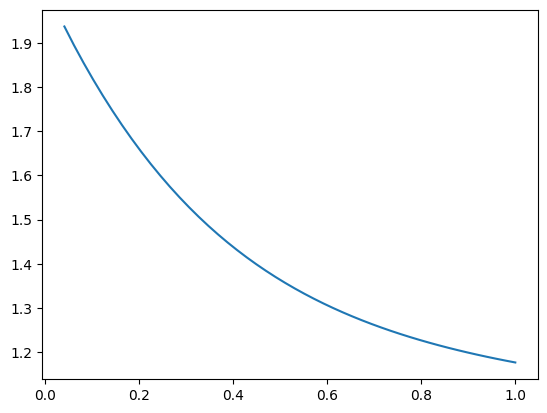

In [76]:
# slope 
msd = pd.DataFrame({"lagt": t, "<x^2>": x2})
msd["slope"] = np.log(msd["<x^2>"]).diff() / np.log(msd["lagt"]).diff()
plt.plot(msd["lagt"], msd["slope"])

#### 3.8.1 Load msd from Data folder

In [69]:
# load MSD data
n = 147
msd_folder = r"..\Data\msd"
msd = pd.read_csv(os.path.join(msd_folder, "{:02d}.csv".format(n)))

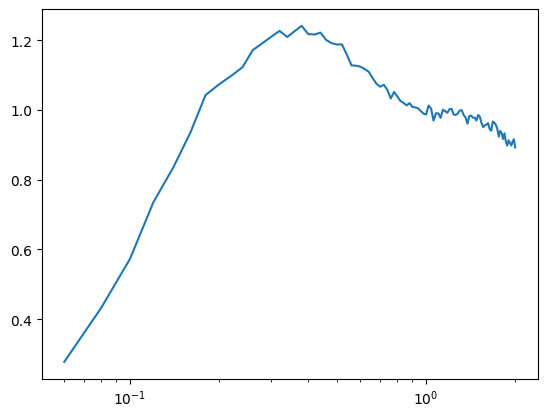

In [70]:
# compute slope \alpha
msd["alpha"] = np.log(msd["<y^2>"]).diff(2) / np.log(msd["lagt"]).diff(2)
plt.plot(msd["lagt"][:100], msd["alpha"][:100])
plt.xscale("log")

In [11]:
type(np.log(msd["<y^2>"]))

pandas.core.series.Series

### 3.9 Symmetric time scale

By observing the expression of MSD, Cristian found that the two time scales, $\tau$ and $\tau^*$, played symmetric roles in the equation. As a result, there are always two sets of fitting parameters that are equally good in fitting error. Remember that the MSD model is the following

$$
\left< \Delta y^2 \right>  = \frac{2 u_b^2 \tau^{*2} \tau}{\tau^{*2} - \tau^2} \left[ \tau^*(1 - e^{-t/\tau^*}) - \tau(1-e^{-t/\tau}) \right].
$$

For example, we determine a set of fitting parameters below:

$$
u_b = 1,\\

$$

it is immediately possible to have another parameter set by swapping $\tau$ and $\tau^*$, i.e.

$$
\tau' = 10,\\
\tau^{*'} = 1.
$$

Here, the square bracket parts are unchanged and we only have to adjust the value of $u_b$ to make the prefactor consistent. In this case,

$$
u_b \tau^{*2} \tau = u_b' \tau^{*'2} \tau',
$$

from which we get $u_b'=10$.

Due to this symmetry, we have to introduce additional conditinos to differentiate the sedimentation time scale and the bath time scale. In this section, we discuss the methods to do this work. 

#### 3.9.1 Estimate sedimentation time

With the spring model, we obtained an expression of sedimentation time scale, which is independent of the bath parameters. Recall the expression is

$$
\tau^* = \frac{9\eta}{\Delta\rho g}\frac{D-d}{d^2}.
$$

Assuming water viscosity and density, we can obtain the sedimentation time scale with just the geometry. This is our **estimate**.

We hypothesize that the real sedimentation time scale is close to this estimate. When we fit the experimental MSD curve and get two time scales, the one that is closer to this estimate is the sedimentation time scale, the other one is the bath time scale.

In the past, we have been always assuming that the shorter time scale belongs to the bath. This may not always be the case.

Here, I plot the $\tau$ and $\tau^*$ from the original fit, as well as the estimates $\tau^*_{est}$ to have an overview of the whole dataset.

In [40]:
df = pd.read_csv(r"C:\Users\liuzy\Downloads\List of experiments - double_emulsion.csv")

In [41]:
df = df.loc[df.Plane=="XZ"]

(0.0, 20.0)

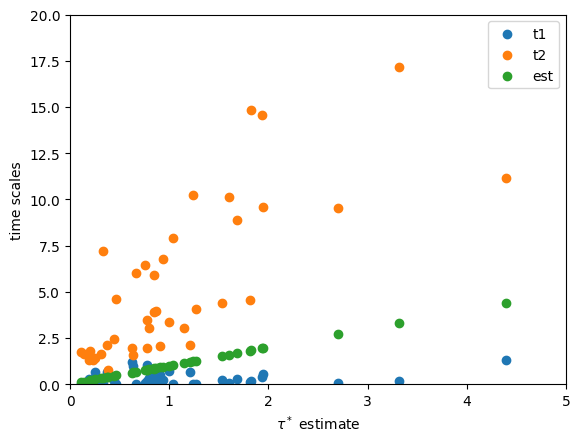

In [45]:
plt.scatter(df.t2_est, df.t1_fit, label="t1")
plt.scatter(df.t2_est, df.t2_fit, label="t2")
plt.scatter(df.t2_est, df.t2_est, label="est")
# plt.loglog()
plt.legend()
plt.xlabel("$\\tau^*$ estimate")
plt.ylabel("time scales")
plt.xlim([0,5])
plt.ylim([0,20])

In [ ]:
df = pd.io.parsers.read_csv()

## 4 Geometry and concentration dependence

We obtain 3 fitting parameters from the MSD fitting: $D_A$, $\tau$ and $\tau^*$. In this section, we discuss the geometry implication from the spring model, and compare with our measurements. 

### 4.0 Parameter space

Only use experiments with $OD\le 100$, and exclude the bad fitting ones.

In [2]:
log = pd.read_excel(r"..\Data\structured_log_DE.ods")
log1 = log.loc[(log.OD<=100)&(log.Fitting!="bad")]

Text(0, 0.5, '$r_i$ ($\\mu$m)')

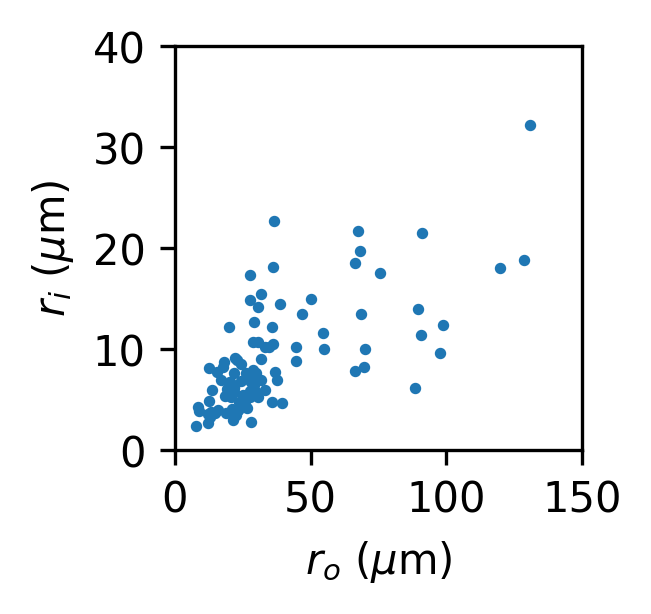

In [3]:
fig, ax = plt.subplots(figsize=(1.75,1.75), dpi=300)
ax.scatter(log1.D/2, log1.d/2, s=3)
ax.set_xlim([0, 150])
ax.set_ylim([0, 40])
ax.set_xlabel("$r_o$ ($\mu$m)")
ax.set_ylabel("$r_i$ ($\mu$m)")

Use different color and marker to separate concentration groups.

In [4]:
colors = plt.cm.get_cmap("tab10")
markers = ["o", "p", ">", "s", "*"]

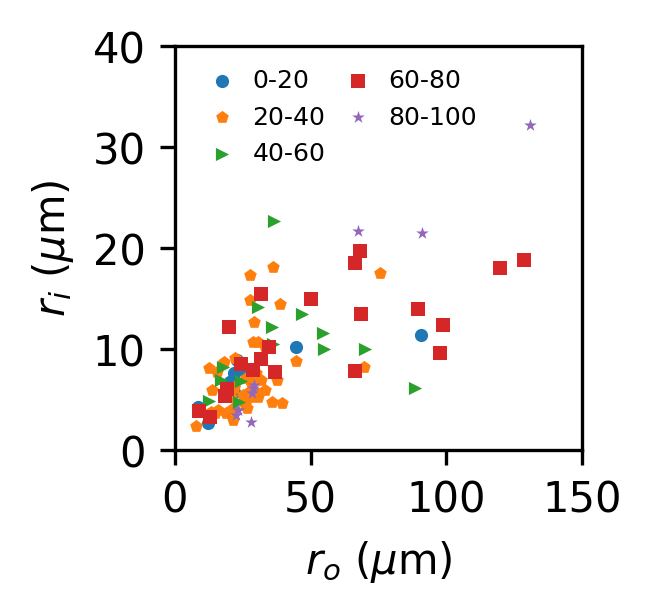

In [5]:
fig, ax = plt.subplots(figsize=(1.75,1.75), dpi=300)
for i in range(5):
    sub = log1.loc[(log1.OD>i*20)&(log1.OD<=i*20+20)]
    ax.scatter(sub.D/2, sub.d/2, s=10, color=colors(i), marker=markers[i], label="{0:d}-{1:d}".format(i*20, i*20+20), lw=0)
ax.legend(fontsize=6, frameon=False, ncol=2, columnspacing=0.3, handletextpad=0.2)
ax.set_xlim([0, 150])
ax.set_ylim([0, 40])
ax.set_xlabel("$r_o$ ($\mu$m)")
ax.set_ylabel("$r_i$ ($\mu$m)")

# plt.tight_layout()
fig.savefig("param-space.pdf")

### 4.1 $D_A$, the active diffusivity

#### 4.1.1 Droplet size 
In the spring model, $D_A$ is a quantity that describes the strength of "active noise", resembling the thermal diffusivity $D_T$ in Brownian motion. In our model, there is no explicit dependence on the outer diameter $D$. From the Stokes-Einstein relation for Brownian motion
$$
D_T = \frac{k_BT}{6\pi\eta a},
$$
however, we infer that $D_A$ has a dependence on the inner droplet size (probe size), i.e. 
$$
D_A \propto \frac{1}{d}.
$$

Here, we plot
- $D_A$ vs. $D$ to see if $D$ is irrelevant
- $D_A$ vs. $d$ to see if the $-1$ exponent exists
- $D_A$ vs. $D-d$ to see if the free space is the actual control parameter
- $D_A$ vs. $(D-d)/d$ to show the best control parameter we have identified

In [25]:
dd1 = de_data(log1)

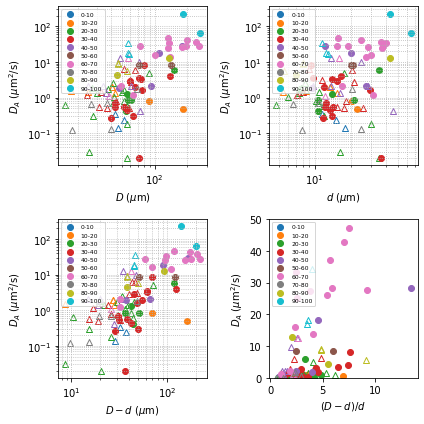

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
dd1.scatter(x="D", y="DA_fit", xlabel="$D$ ($\mu$m)", ylabel="$D_A$ ($\mu$m$^2$/s)", mode="log", ax=ax[0][0])
dd1.scatter(x="d", y="DA_fit", xlabel="$d$ ($\mu$m)", ylabel="$D_A$ ($\mu$m$^2$/s)", mode="log", ax=ax[0][1])
dd1.scatter(x="D-d", y="DA_fit", xlabel="$D-d$ ($\mu$m)", ylabel="$D_A$ ($\mu$m$^2$/s)", mode="log", ax=ax[1][0])
dd1.scatter(x="(D-d)/d", y="DA_fit", xlabel="$(D-d)/d$", ylabel="$D_A$ ($\mu$m$^2$/s)", mode="lin", ax=ax[1][1])
plt.ylim([0, 50])
# ax[1][1].set_ylim([0, 50])
plt.tight_layout()

#### 4.1.2 Concentration dependence of $D_A$

From the $D_A$ vs. $(D-d)/d$ plot, we can see a pronounced concentration dependence of $D_A$: low concentration points are below the high concentration points! What is the exact nature of this dependence? Let's choose a small range of $(D-d)/d$, and plot $D_A$ as a function of OD.

[]

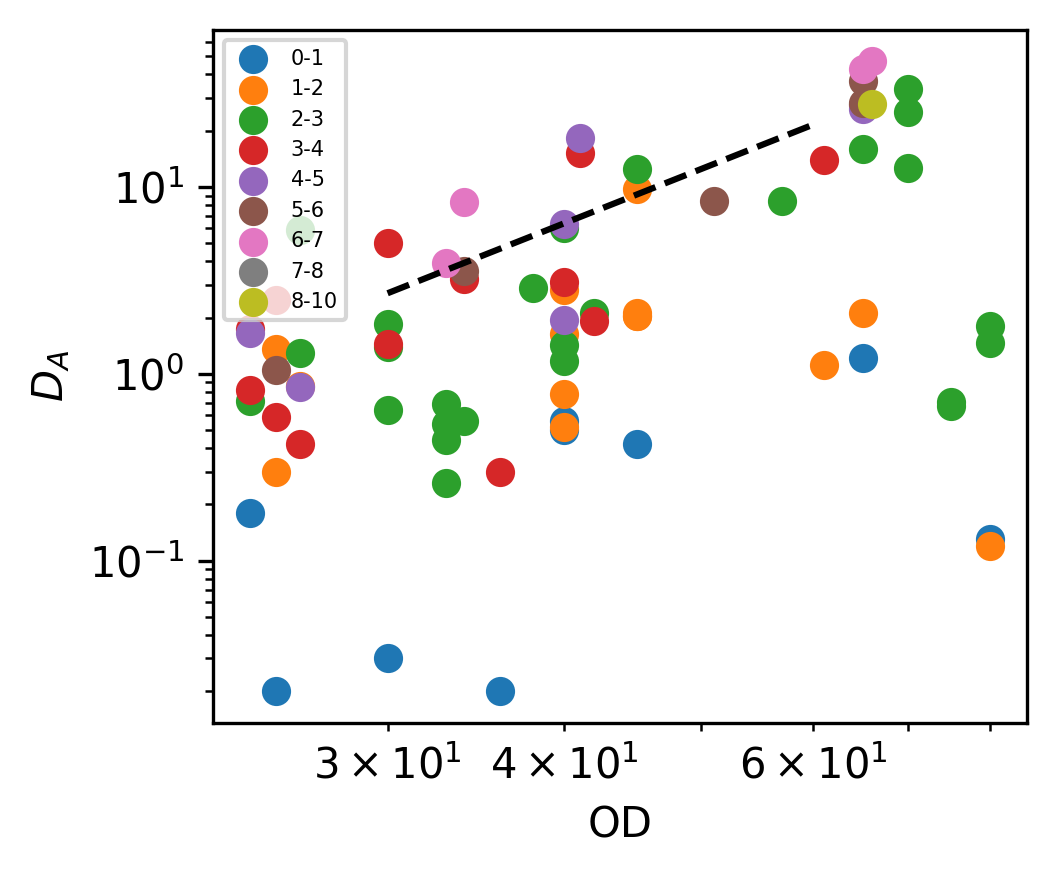

In [1270]:
fig, ax = plt.subplots(figsize=(3.5, 3),dpi=300)
d_bins = np.linspace(0, 10, 10)
binsize = d_bins[1] - d_bins[0]
for start in d_bins[:-1]:
    end = start + binsize
    sublog = log1.loc[(log["(D-d)/d"]>=start)&(log["(D-d)/d"]<end)]
    ax.scatter(sublog.OD, sublog.DA_fit, label="{0:d}-{1:d}".format(int(start), int(end)))
ax.legend(loc="upper left", fontsize=5)
ax.set_xlabel("OD")
ax.set_ylabel("$D_A$")
# ax.set_xlim([0, 80])
# ax.set_ylim([0, 30])
x = np.array([30, 60])
y = 0.0001 * x ** 3
ax.plot(x, y, color="black", ls="--")
ax.loglog()

#### 4.1.3 Examine data in OD bins

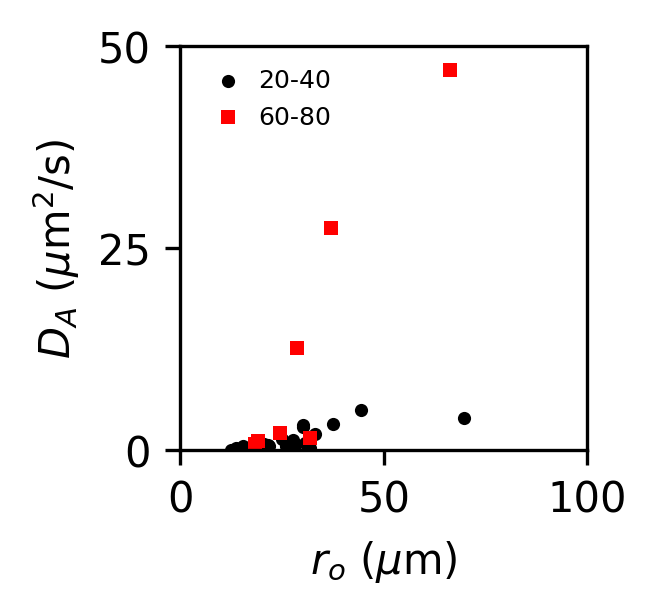

In [44]:
ri_bin = [5, 9]
OD_bin1 = [20, 40]
log2 = log1.loc[(log1.OD>OD_bin1[0])&(log1.OD<=OD_bin1[1])&(log1.d/2>ri_bin[0])&(log1.d/2<=ri_bin[1])]
OD_bin2 = [60, 80]
log3 = log1.loc[(log1.OD>OD_bin2[0])&(log1.OD<=OD_bin2[1])&(log1.d/2>ri_bin[0])&(log1.d/2<=ri_bin[1])]
fig, ax = plt.subplots(figsize=(1.75, 1.75), dpi=300)
ax.scatter(log2.D/2, log2.DA_fit, color="black", label="{0:d}-{1:d}".format(*OD_bin1), lw=0, s=10, marker="o")
ax.scatter(log3.D/2, log3.DA_fit, color="red", label="{0:d}-{1:d}".format(*OD_bin2), lw=0, s=10, marker="s")
ax.legend(fontsize=6, frameon=False, columnspacing=0.3, handletextpad=0.2)
ax.set_xlabel("$r_o$ ($\mu$m)")
ax.set_ylabel("$D_A$ ($\mu$m$^2$/s)")
ax.set_xlim([0, 100])
ax.set_ylim([0, 50])
ax.set_yticks([0,25,50])
ax.set_yticklabels([0,25,50])
fig.savefig("DA_ro.pdf")

### 4.2 $\tau$, correlation time of "active noise"

#### 4.2.1 Droplet size

<font color="blue">This data set currently only contains OD in [20, 40], complete $\tau$ data in the future. </font>

$\tau$ is the correlation time of the stochastic "active noise". When lag time is greater than $\tau$, the correlation between the noise at different times vanishes. The model does not provide explicit prediction on this value. In fact, it is assumed a constant, independent of both bacterial concentration and geometry.

Here, we plot
- $\tau$ vs. $D$
- $\tau$ vs. $d$
- $\tau$ vs. $D-d$
- $\tau$ vs. $(D-d)/d$, I don't know why but just to fill the panels

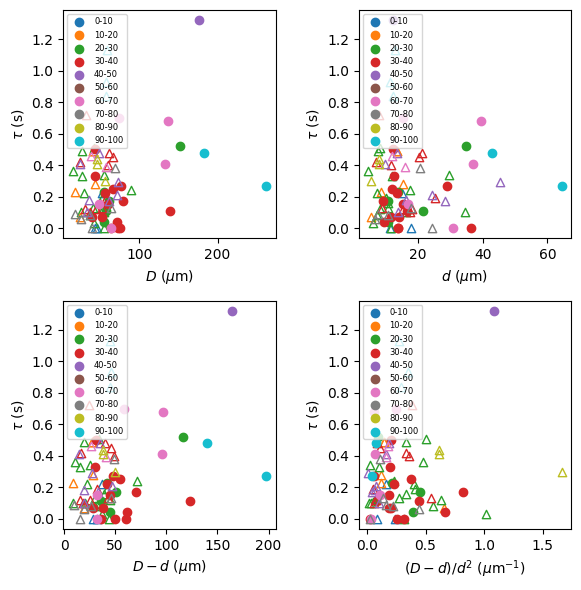

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
dd1.scatter(x="D", y="t1_fit", xlabel="$D$ ($\mu$m)", ylabel="$\\tau$ (s)", mode="lin", ax=ax[0][0])
dd1.scatter(x="d", y="t1_fit", xlabel="$d$ ($\mu$m)", ylabel="$\\tau$ (s)", mode="lin", ax=ax[0][1])
dd1.scatter(x="D-d", y="t1_fit", xlabel="$D-d$ ($\mu$m)", ylabel="$\\tau$ (s)", mode="lin", ax=ax[1][0])
dd1.scatter(x="(D-d)/d^2", y="t1_fit", xlabel="$(D-d)/d^2$ ($\mu$m$^{-1}$)", ylabel="$\\tau$ (s)", mode="lin", ax=ax[1][1])
plt.tight_layout()

#### 4.2.2 Concentration dependence

(0.0, 0.3)

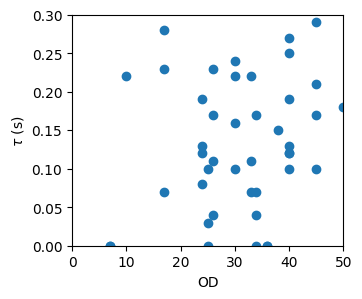

In [46]:
fig, ax = plt.subplots(figsize=(3.5, 3))
ax.scatter(log1.OD, log1.t1_fit)
ax.set_xlabel("OD")
ax.set_ylabel("$\\tau$ (s)")
ax.set_xlim([0, 50])
ax.set_ylim([0, .30])

#### 4.2.3 Examine $\tau$ in OD and $r_i$ bins

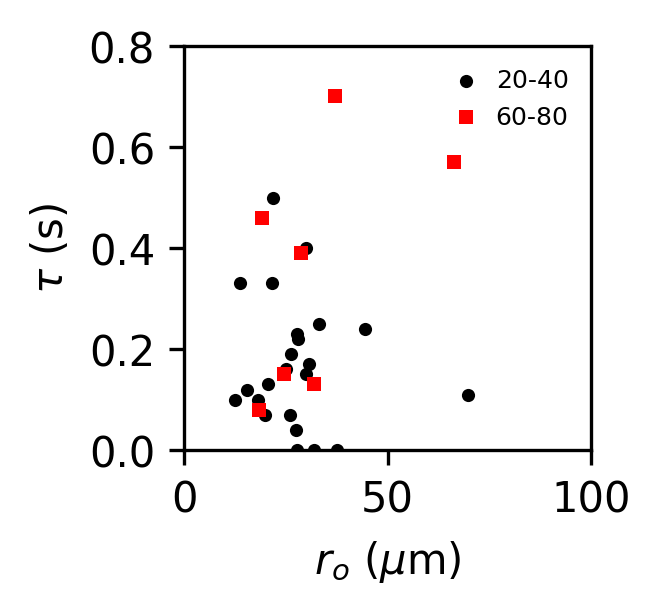

In [3]:
ri_bin = [5, 9]
OD_bin1 = [20, 40]
log2 = log1.loc[(log1.OD>OD_bin1[0])&(log1.OD<=OD_bin1[1])&(log1.d/2>ri_bin[0])&(log1.d/2<=ri_bin[1])]
OD_bin2 = [60, 80]
log3 = log1.loc[(log1.OD>OD_bin2[0])&(log1.OD<=OD_bin2[1])&(log1.d/2>ri_bin[0])&(log1.d/2<=ri_bin[1])]
fig, ax = plt.subplots(figsize=(1.75, 1.75), dpi=300)
ax.scatter(log2.D/2, log2.t1_fit, color="black", label="{0:d}-{1:d}".format(*OD_bin1), lw=0, s=10, marker="o")
ax.scatter(log3.D/2, log3.t1_fit, color="red", label="{0:d}-{1:d}".format(*OD_bin2), lw=0, s=10, marker="s")
ax.legend(fontsize=6, frameon=False, columnspacing=0.3, handletextpad=0.2)
ax.set_xlabel("$r_o$ ($\mu$m)")
ax.set_ylabel("$\\tau$ (s)")
ax.set_xlim([0, 100])
ax.set_ylim([0, 0.8])
# ax.set_yticks([0,25,50])
# ax.set_yticklabels([0,25,50])
fig.savefig("tau_ro.pdf")

### 4.3 $\tau^*$, relaxation time of the confined fluctuation


#### 4.3.1 Droplet sizes

The spring model predicts the relaxation time $\tau^*$ as:
$$
\tau^* = \frac{9\eta}{\Delta\rho g}\frac{D-d}{d^2}.
$$
This prediction is rather quantitative and therefore easy to verify. More interestingly, $\tau^*$ is independent of bacterial concentration, which provides additional qualitative measure for verifying the prediction.

Here, we plot
- $\tau^*$ vs. $D$
- $\tau^*$ vs. $d$
- $\tau^*$ vs. $D-d$
- $\tau^*$ vs. $(D-d)/d^2$ as predicted

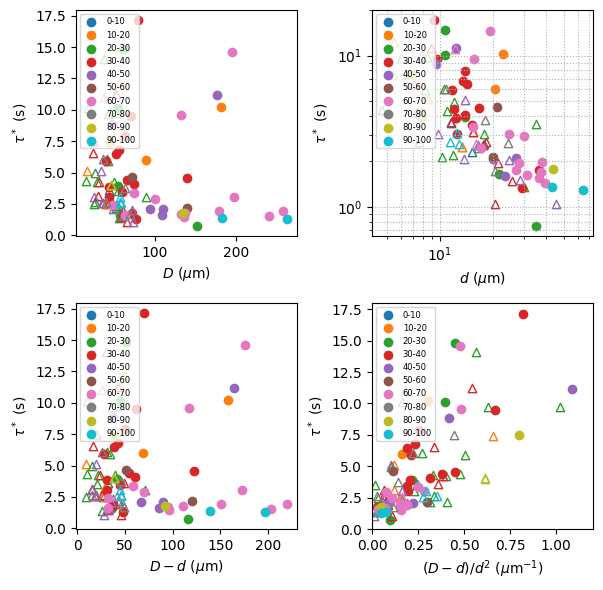

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
dd1.scatter(x="D", y="t2_fit", xlabel="$D$ ($\mu$m)", ylabel="$\\tau^*$ (s)", mode="lin", ax=ax[0][0])
dd1.scatter(x="d", y="t2_fit", xlabel="$d$ ($\mu$m)", ylabel="$\\tau^*$ (s)", mode="log", ax=ax[0][1])
dd1.scatter(x="D-d", y="t2_fit", xlabel="$D-d$ ($\mu$m)", ylabel="$\\tau^*$ (s)", mode="lin", ax=ax[1][0])
dd1.scatter(x="(D-d)/d^2", y="t2_fit", xlabel="$(D-d)/d^2$ ($\mu$m$^{-1}$)", ylabel="$\\tau^*$ (s)", mode="lin", ax=ax[1][1])
plt.xlim([0, 1.2])
plt.ylim([0, 18])
plt.tight_layout()

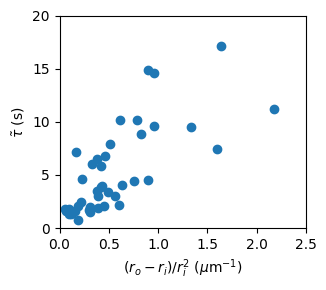

In [89]:
log2 = log.loc[(log["Fitting"]!="bad")&(log["Move"]!=1)&(log["Comment"]!="Chile")]
plt.figure(figsize=(3.5, 3))
plt.scatter(log2["(D-d)/d^2"]*2, log2["t2_fit"])
plt.xlabel("$(r_o-r_i)/r_i^2$ ($\mu$m$^{-1}$)")
plt.ylabel("$\\tilde\\tau$ (s)")
plt.xlim([0, 2.5])
plt.ylim([0, 20])
plt.tight_layout()
plt.savefig("saturation-time.pdf")

With new OD 20-40 data added, the linear relation becomes much more convincing.

#### 4.3.2 Concentration dependence

(0.0, 15.0)

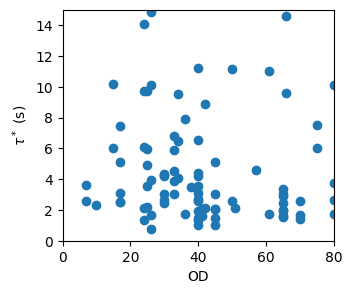

In [4]:
fig, ax = plt.subplots(figsize=(3.5, 3))
ax.scatter(log1.OD, log1.t2_fit)
ax.set_xlabel("OD")
ax.set_ylabel("$\\tau^*$ (s)")
ax.set_xlim([0, 80])
ax.set_ylim([0, 15])

The $\tau^*$ result above shows good linear dependence on $(D-d)/d^2$. This has inspired us to use theoretical $\tau^*$ as a given constant and fit for $\tau$ and $D_A$. <font color="blue">To be done</font>

#### 4.3.3 Examine $\tau^*$ in OD and $r_i$ bins

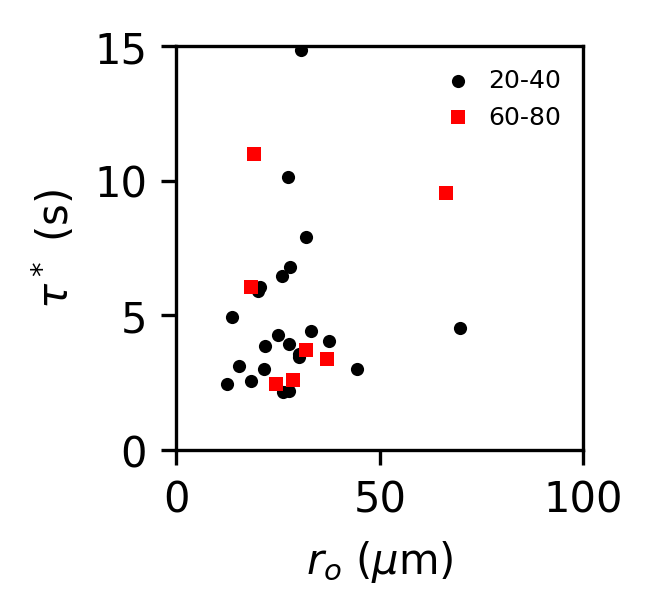

In [6]:
ri_bin = [5, 9]
OD_bin1 = [20, 40]
log2 = log1.loc[(log1.OD>OD_bin1[0])&(log1.OD<=OD_bin1[1])&(log1.d/2>ri_bin[0])&(log1.d/2<=ri_bin[1])]
OD_bin2 = [60, 80]
log3 = log1.loc[(log1.OD>OD_bin2[0])&(log1.OD<=OD_bin2[1])&(log1.d/2>ri_bin[0])&(log1.d/2<=ri_bin[1])]
fig, ax = plt.subplots(figsize=(1.75, 1.75), dpi=300)
ax.scatter(log2.D/2, log2.t2_fit, color="black", label="{0:d}-{1:d}".format(*OD_bin1), lw=0, s=10, marker="o")
ax.scatter(log3.D/2, log3.t2_fit, color="red", label="{0:d}-{1:d}".format(*OD_bin2), lw=0, s=10, marker="s")
ax.legend(fontsize=6, frameon=False, columnspacing=0.3, handletextpad=0.2)
ax.set_xlabel("$r_o$ ($\mu$m)")
ax.set_ylabel("$\\tau^*$ (s)")
ax.set_xlim([0, 100])
ax.set_ylim([0, 15])
# ax.set_yticks([0,25,50])
# ax.set_yticklabels([0,25,50])
fig.savefig("tau2_ro.pdf")

### 4.4 Generate whole figure using code, so it's easier to change parameters

| param space | DA-ro | tau-ro | tau*-ro |
|-------------|-------|--------|---------|
| param space | DA-ri | tau-ri | tau*-ri |

In [17]:
log = pd.read_excel(r"..\Data\structured_log_DE.ods")
log1 = log.loc[(log.OD<=100)&(log.Fitting!="bad")]

In [18]:
# first row data, fix OD and r_i in (5, 9)
ri_bin = [5, 9]
OD_bin1 = [20, 40]
OD_bin2 = [60, 80]
log2 = log1.loc[(log1.OD>OD_bin1[0])&(log1.OD<=OD_bin1[1])&(log1.d/2>ri_bin[0])&(log1.d/2<=ri_bin[1])]
log3 = log1.loc[(log1.OD>OD_bin2[0])&(log1.OD<=OD_bin2[1])&(log1.d/2>ri_bin[0])&(log1.d/2<=ri_bin[1])]

In [19]:
# first row data, fix OD and r_o in (30, 50)
ro_bin = [30, 50]
OD_bin1 = [20, 40]
OD_bin2 = [60, 80]
log4 = log1.loc[(log1.OD>OD_bin1[0])&(log1.OD<=OD_bin1[1])&(log1.D/2>ro_bin[0])&(log1.D/2<=ro_bin[1])]
log5 = log1.loc[(log1.OD>OD_bin2[0])&(log1.OD<=OD_bin2[1])&(log1.D/2>ro_bin[0])&(log1.D/2<=ro_bin[1])]

In [21]:
# define marker and colors for parameter space plot
colors = plt.cm.get_cmap("viridis", 5)
markers = ["o", "p", ">", "s", "*"]

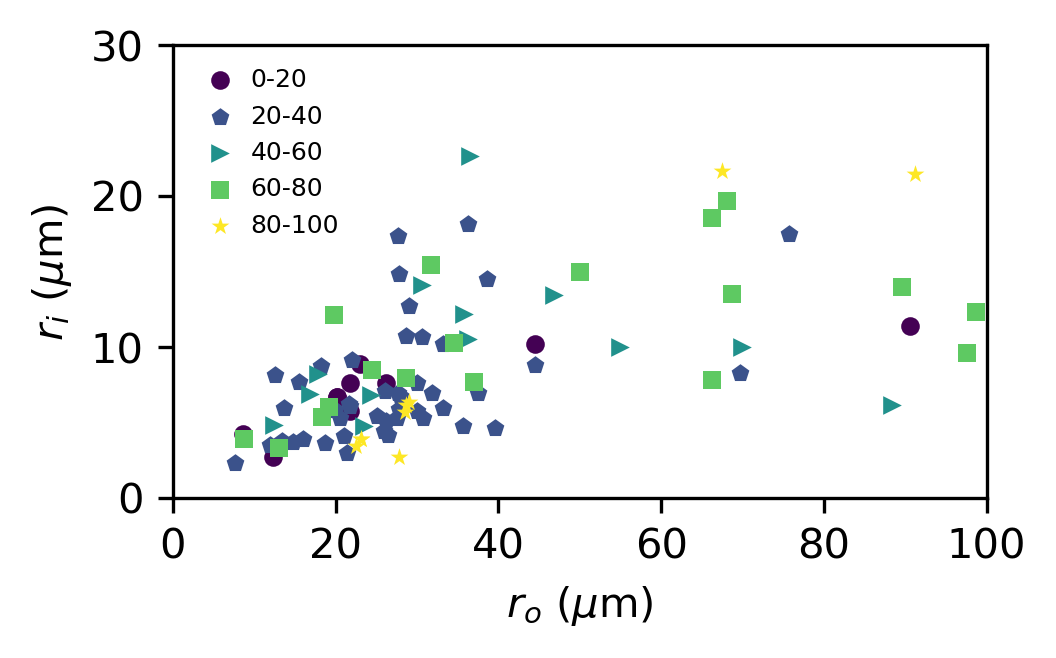

In [22]:
# plot parameter space with indications of r_o, r_i bins, # 1-1 and 1-2 (combined)
fig, ax = plt. subplots(figsize=(3.5, 2), dpi=300)
for i in range(5):
    sub = log1.loc[(log1.OD>i*20)&(log1.OD<=i*20+20)]
    ax.scatter(sub.D/2, sub.d/2, s=20, color=colors(i), marker=markers[i], label="{0:d}-{1:d}".format(i*20, i*20+20), lw=0)
ax.legend(fontsize=6, frameon=False, columnspacing=0.3, handletextpad=0.2)
ax.set_xlim([0, 100])
ax.set_ylim([0, 30])
ax.set_xlabel("$r_o$ ($\mu$m)")
ax.set_ylabel("$r_i$ ($\mu$m)")

fig.savefig("param-space.pdf")

C:\Users\liuzy\AppData\Local\Temp\ipykernel_8772\2525332314.py:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[2][0].set_xlim([0, 100])


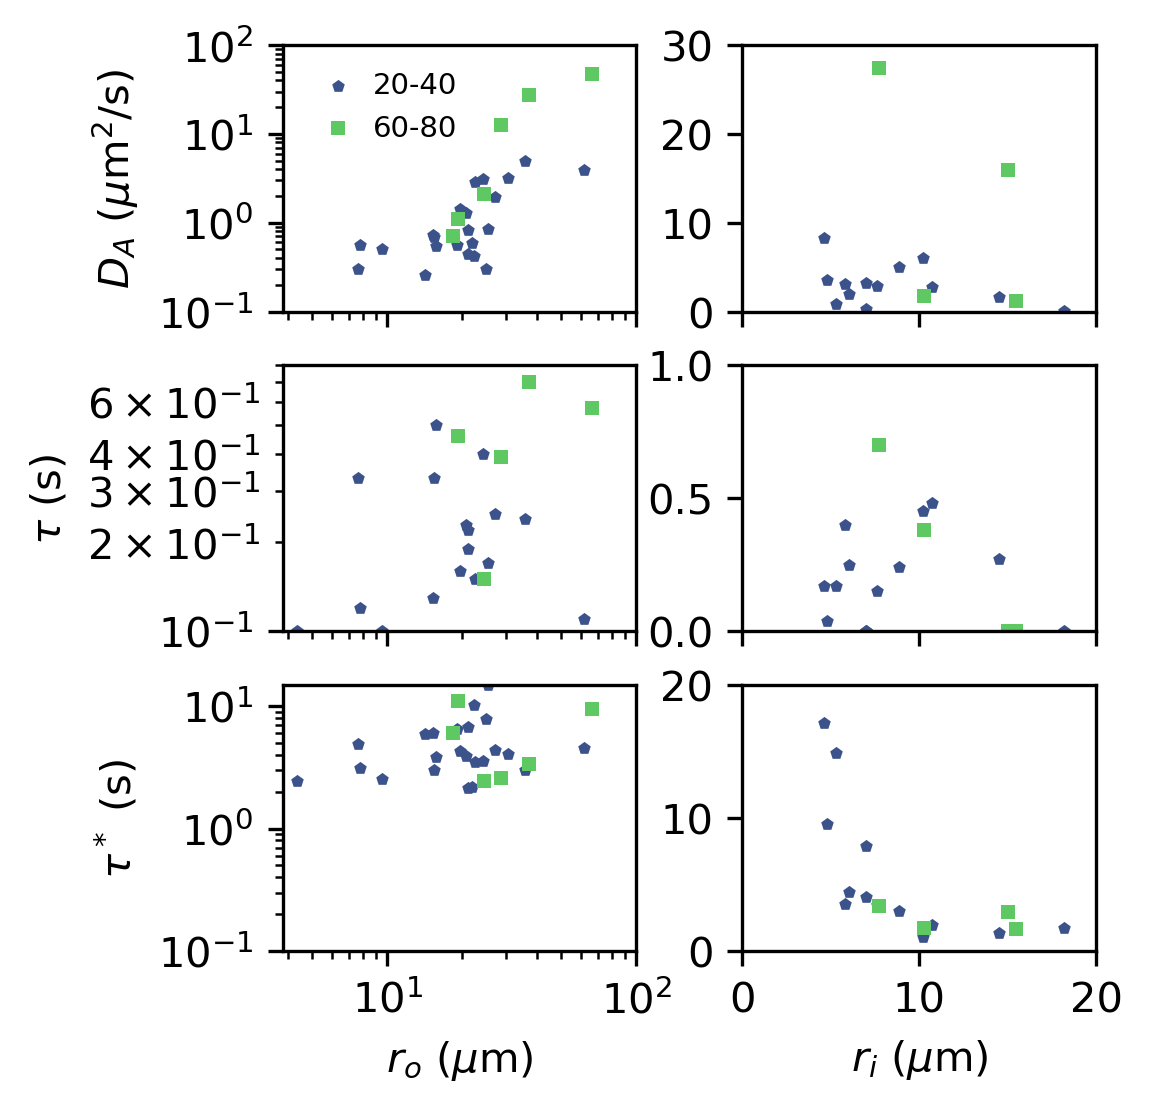

In [33]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(3.5, 4), dpi=300, sharex="col", gridspec_kw={"wspace": 0.3})

# 1-2, 1-3, 1-4
items = {0: "DA_fit", 1: "t1_fit", 2:"t2_fit"}
labels = {0: "$D_A$ ($\mu$m$^2$/s)", 1: "$\\tau$ (s)", 2: "$\\tau^*$ (s)"}
yUpperLims = {0: 100, 1: 0.8, 2: 15}
for i in range(3):
    ax[i][0].scatter(log2.D/2-log2.d/2, log2[items[i]], color=colors(1), marker=markers[1], label="{0:d}-{1:d}".format(*OD_bin1), lw=0, s=10)
    ax[i][0].scatter(log3.D/2, log3[items[i]], color=colors(3), marker=markers[3], label="{0:d}-{1:d}".format(*OD_bin2), lw=0, s=10)
    
    ax[i][0].set_ylabel(labels[i])
    ax[i][0].set_ylim([.1, yUpperLims[i]])
    ax[i][0].loglog()
ax[0][0].legend(fontsize=7, frameon=False, columnspacing=0.3, handletextpad=0.2, loc="upper left")    
# x-axis overall settings
ax[2][0].set_xlim([0, 100])
ax[2][0].set_xlabel("$r_o$ ($\mu$m)")

# 2-2, 2-3, 2-4
yUpperLims = {0: 30, 1: 1, 2: 20}
for i in range(3):
    ax[i][1].scatter(log4.d/2, log4[items[i]], color=colors(1), marker=markers[1], label="{0:d}-{1:d}".format(*OD_bin1), lw=0, s=10)
    ax[i][1].scatter(log5.d/2, log5[items[i]], color=colors(3), marker=markers[3], label="{0:d}-{1:d}".format(*OD_bin2), lw=0, s=10)
    # ax[i][1].legend(fontsize=6, frameon=False, columnspacing=0.3, handletextpad=0.2)
    # ax[i][1].set_ylabel(labels[i])
    ax[i][1].set_ylim([0, yUpperLims[i]])
    
# x-axis overall settings
ax[2][1].set_xlim([0, 20])
ax[i][1].set_xlabel("$r_i$ ($\mu$m)")

# plt.tight_layout()
fig.savefig("variables.pdf")

In [56]:
log5

,Date,Video#,DE#,MPP,FPS,OD,D,D_err,d,d_err,...,(D-d)/d,DA/OD,c,number of bacteria,mean velocity (1s),mean velocity middle,mean velocity end,Unnamed: 30,Fitting,Steadiness
1,2021-10-26,12,24,0.11,50.0,65,74.0,NaN,15.4,NaN,...,3.805195,0.422615,0.888277,10928.105509,1.716,NaN,NaN,NaN,NaN,1.020376
2,2021-10-26,13,25,0.11,50.0,65,63.4,NaN,30.9,NaN,...,1.051780,0.018615,0.259675,6132.156606,0.847,NaN,NaN,NaN,NaN,0.988144
12,2021-11-02,16,43,0.11,50.0,65,100.0,NaN,30.0,NaN,...,2.333333,0.245301,0.623415,26478.573333,1.480,9.06,13.0,NaN,NaN,2.043921
71,NaT,experimentoDE_510121_OD80_50fps_exp1,116,0.11,50.0,80,69.1,NaN,20.5,NaN,...,2.370732,0.022500,0.053069,10762.220079,NaN,NaN,NaN,NaN,NaN,1.381877
73,NaT,experimentoDE_510121_OD80_50fps_exp1002,118,0.11,50.0,80,63.7,NaN,18.0,NaN,...,2.538889,0.018375,0.026908,8461.851290,NaN,NaN,NaN,NaN,NaN,0.963224


## 5 Bacterial activity

The confinement effect on the active diffusivity may be correlated with the bacterial activity. Indeed, we frequently observed very different activity at the same bacterial concentration. In order to quantify the activity, we perform PIV analysis on the bright field images of active double emulsions and use the root mean square of the PIV velocity magnitude as a measure of activity. Formally, we obtain velocity magnitude $V_{ij}$ from PIV. The mean velocity is defined as
$$
\overline V = \sqrt {\frac{1}{n}\sum_{ij} V_{ij}^2}.
$$
To suppress noise from the detection, mean velocities measured in multiple frames are averaged. In the data presented here, all the PIV analysis are performed with OpenPIV (version 0.24.2). We fix the interrogation window size at 20 pixels throughout all the analyses, with overlap between adjacent windows at 10 pixels. 

### 5.0 Utility code

Some data manipulation snippets.

#### 5.0.1 Get preview tif images

In [14]:
log = pd.read_excel(r"..\Data\structured_log_DE.ods")
log1 = log.loc[(log.OD<=100)&(log.Fitting!="bad")&(log.Comment!="Chile")]

In [16]:
preview_folder = r"C:\Users\liuzy\Documents\collect_preview"
de_folder = r"C:\Users\liuzy\Documents\de_preview"
if os.path.exists(de_folder) == False:
    os.makedirs(de_folder)
for num, i in log1.iterrows():
    filename = "{0}-{1:02d}.tif".format(i.Date.strftime("%m%d%Y"), i["Video#"])
    src = os.path.join(preview_folder, filename)
    dest = os.path.join(de_folder, "{:03d}.tif".format(i["DE#"]))
    if os.path.exists(src) and os.path.exists(dest) == False:
        shutil.copy(src, dest)

### 5.1 Mean velocity vs. droplet size

In [57]:
log = pd.read_excel(r"..\Data\structured_log_DE.ods")
log1 = log.loc[(log.OD<=100)&(log.Fitting!="bad")]

In [59]:
# define marker and colors for parameter space plot
colors = plt.cm.get_cmap("viridis", 5)
markers = ["o", "p", ">", "s", "*"]

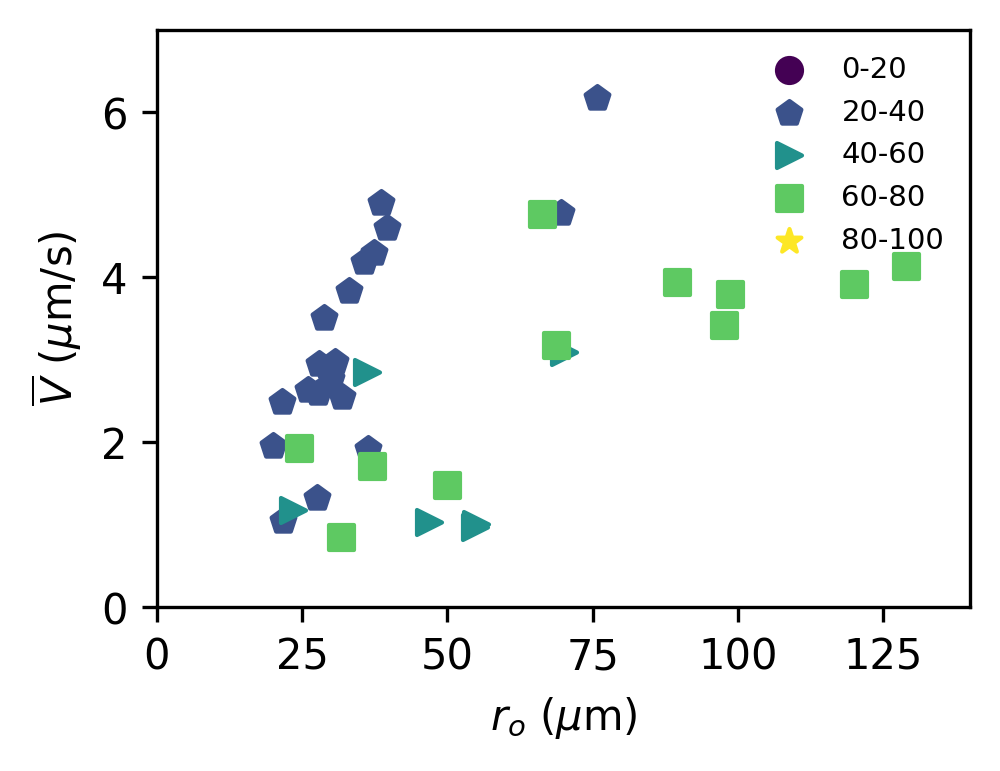

In [73]:
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300)
for i in range(5):
    sub = log1.loc[(log1.OD>i*20)&(log1.OD<=i*20+20)]
    ax.scatter(sub.D/2, sub["mean velocity (1s)"], color=colors(i), marker=markers[i], label="{0:d}-{1:d}".format(i*20, i*20+20))
ax.legend(fontsize=7, frameon=False)
ax.set_xlabel("$r_o$ ($\mu$m)")
ax.set_ylabel("$\overline{V}$ ($\mu$m/s)")
ax.set_xlim([0, 140])
ax.set_ylim([0, 7])

fig.savefig("activity-PIV.pdf")

### 5.2 Temporal evolution of mean velocity

(0.0, 12.0)

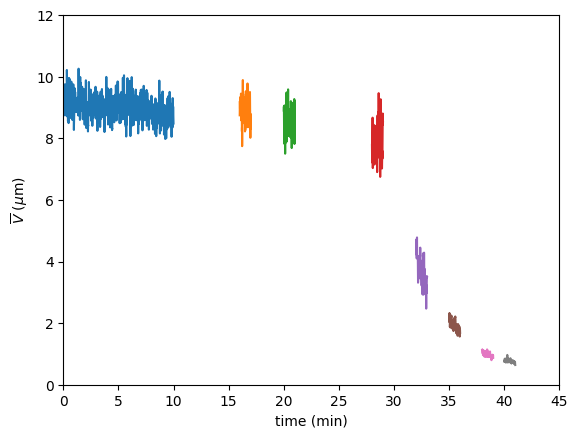

In [16]:
folder = r"C:\Users\liuzy\Documents\01172022\mean_velocity"
fps = 50
mpp = 0.16
offset = [0, 16, 20, 23, 25, 28, 32, 35, 38, 40]
for i in range(10):
    if i == 4 or i == 3:
        continue
    mv = pd.read_csv(os.path.join(folder, "{:02d}.csv".format(i)))
    plt.plot(mv.frame/fps/60+offset[i], gaussian_filter1d(mv.mean_v, sigma=10)*mpp)
plt.xlabel("time (min)")
plt.ylabel("$\overline{V}$ ($\mu$m)")
plt.xlim([0, 45])
plt.ylim([0, 12])

In [4]:
mv

,frame,mean_v
0,0,13.666027
1,2,11.794999
2,4,11.433648
3,6,13.868268
4,8,12.784292
...,...,...
1495,2990,10.568443
1496,2992,9.365245
1497,2994,9.574442
1498,2996,9.561913


## 6 Minimal model and collision angle argument

Wu & Libchaber and Mino et al. suggest that the active diffusivity depends linearly on the concentration of bacteria. We start with the "bacterial flux" model from Mino et al.:
$$
D_A = D_0 + \beta n v
$$
Assuming that all the bacteria have same velocity and the coef $\beta$ is a constant, we can plot $D_A$ vs. $n$ and expect a linear relation.

### 6.1 Collision angle

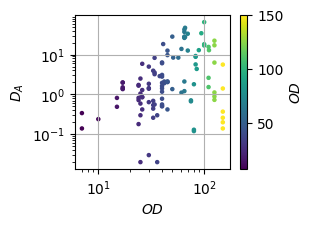

In [10]:
plt.figure(figsize=(2.5, 2))
plt.scatter(log1.OD, log1.DA_fit, c=log1.OD, s=5)
plt.loglog()
plt.xlabel("$OD$")
plt.ylabel("$D_A$")
plt.grid()
plt.colorbar(label="$OD$")
plt.savefig("DA_OD.pdf")

This is clearly not linear and very scattered, because of the confinement. Now, we start to build simple geometry argument onto this model. First, we consider the efficiency of momentum transfer from bacteria to inner droplet in confinement. As sketched below, we consider that bacteria alway follow the direction of outer boundary when they swim. Therefore, their effective velocity is only the horizontal component. The model is modified to:
$$
D_A = D_0 + \beta n v \cos\theta = D_0 + \beta n v\frac{\sqrt{(R-r)^2-r^2}}{R-r}
$$
In the case where $r>R/2$, we take $\cos\theta=0$. So in the end we plot $D_A$ vs. $nf(R, r)$, where 
$$
f(R, r) = 
\begin{cases}
\frac{\sqrt{(R-r)^2-r^2}}{R-r}, & \text{if}\; r\le R/2 \\
0, & \text{if}\; r > R/2
\end{cases}
$$

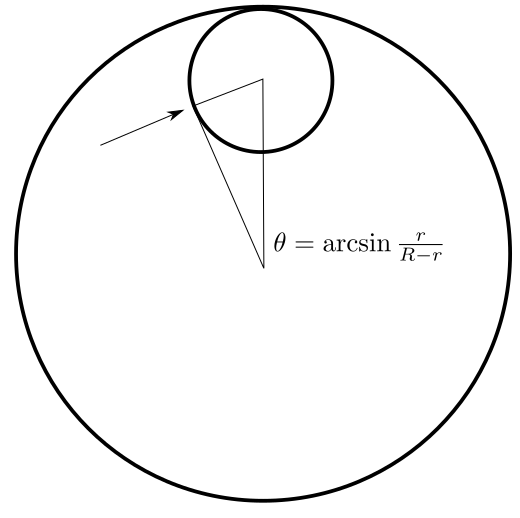

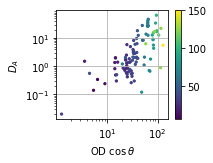

In [5]:
def compute_f(R, r):
    """Compute the geometrical factor defined above."""
    f = np.zeros(R.shape)
    ind = R >= 2*r
    f[ind] = ((R[ind]-r[ind])**2 - r[ind]**2) ** 0.5 / (R[ind] - r[ind])
    return f

# log = log.query("index not in [84, 115, 119, 120, 121, 172]")
x = log1.OD*compute_f(log1.D, log1.d)
y = log1.DA_fit
plt.figure(figsize=(2.5, 2))
plt.scatter(x, y, c=log1.OD, s=5)
# for num, i in log1.iterrows():
#     plt.annotate(num, (x.loc[num], y.loc[num]), xycoords="data")
plt.loglog()
plt.xlabel("OD $\cos\\theta$")
plt.ylabel("$D_A$")
plt.grid()
plt.colorbar()
# plt.xlim([0, 100])
# plt.ylim([0, 50])
plt.savefig("DA_ODcost.pdf")

### 6.2 Include size-dependent activity

Previously, we assume the velocity to be a constant in all droplets. Hence, we plot $D_A$ only as a function of OD and the geometrical term. However, we notice that the activity of bacteria, measured by the mean PIV velocity, depends also on the outer droplet size. In general, larger droplet gives rise to larger mean velocity. This leads us to consider using an additional outer droplet size term to collapse the data. 

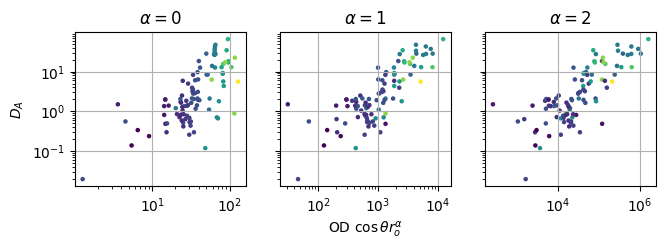

In [33]:
fig, ax = plt.subplots(ncols=3, figsize=(7.5, 2), sharey=True)

for i, a in enumerate([0, 1, 2]):
    x = log1.OD*compute_f(log1.D, log1.d)*(log1.D/2)**a
    y = log1.DA_fit
    ax[i].scatter(x, y, c=log1.OD, s=5)
    # for num, i in log1.iterrows():
    #     plt.annotate(num, (x.loc[num], y.loc[num]), xycoords="data")
    ax[i].loglog()
    
    ax[i].grid()
    ax[i].set_title("$\\alpha={:d}$".format(a))
ax[0].set_ylabel("$D_A$")
ax[1].set_xlabel("OD $\cos\\theta r_o^\\alpha$")
# plt.colorbar()
# plt.xlim([0, 100])
# plt.ylim([0, 50])
plt.savefig("DA_ODcostro.pdf")

Generate animation.

In [15]:
folder = r"C:\Users\liuzy\Documents\output"

for i, a in enumerate(np.linspace(0, 2)):
    fig, ax = plt.subplots(figsize=(3.5, 3), dpi=200)
    x = log1.OD*compute_f(log1.D, log1.d)*(log1.D/2)**a
    y = log1.DA_fit
    ax.scatter(x, y, c=log1.OD, s=5)
    norm = colors.Normalize(vmin=0, vmax=100)
    sm = cm.ScalarMappable(norm=norm, cmap="viridis")
    plt.colorbar(mappable=sm, ax=ax)
    # for num, i in log1.iterrows():
    #     plt.annotate(num, (x.loc[num], y.loc[num]), xycoords="data")
    ax.loglog()
    ax.grid()
    ax.set_title("$\\alpha={:.2f}$".format(a))
    ax.set_ylabel("$D_A$")
    ax.set_xlabel("OD $\cos\\theta r_o^\\alpha$")
    
    # ax.set_xlim([0, 100])
    # ax.set_ylim([0, 50])
    plt.tight_layout()
    fig.savefig(os.path.join(folder, "{:03d}.jpg".format(i)))

    plt.close(fig)

# plt.savefig("DA_ODcostro.pdf")

### 6.3 Inner droplet size

To account for different inner droplet sizes, we use $D_Ad$ as the vertical axis. 

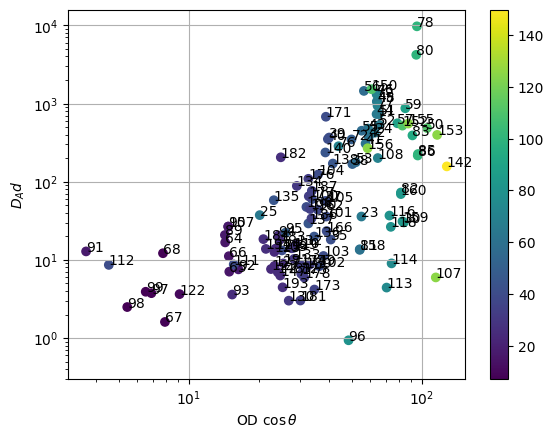

In [32]:
log = log.query("index not in [84, 115, 119, 120, 121, 172]")
x = log.OD*compute_f(log.D, log.d)
y = log.DA_fit * log.d
plt.scatter(x, y, c=log.OD)
for num, i in log.iterrows():
    plt.annotate(num, (x.loc[num], y.loc[num]), xycoords="data")
plt.loglog()
plt.xlabel("OD $\cos\\theta$")
plt.ylabel("$D_Ad$")
plt.grid()
plt.colorbar()

I notice that the activity of bacteria tend to increase with outer droplet size. This is true even for low concentration bacterial suspensions (D<40), where collective motion is not onset. A simple model (or a simple dimensional analysis) suggests that the active diffusivity $D_A$ scales with $v^2$, where $v$ is a measure of bacterial activity in the sense of velocity. Here, we want to consider this effect, by plotting $D_Ad$ agains $(OD\cos\theta) \cdot D^\alpha$. Since the relation between $D$ and $v$ is not clear (from OD 20-40 data we clearly see it's positively correlated, it's just not clear in a more quantitative sense). Therefore, we vary $\alpha$ from 0 to 2, to see how it changes the collapse of the data.

In [47]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [55]:
out_folder = r"C:\Users\liuzy\Desktop\imgs"
alpha = np.linspace(0, 2)
y = log.DA_fit * log.d
count = 0
for a in alpha:
    x = log.OD*compute_f(log.D, log.d) * log.D ** a
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=log.OD)
    for num, i in log.iterrows():
        ax.annotate(num, (x.loc[num], y.loc[num]), xycoords="data")
    ax.loglog()
    ax.set_xlabel("(OD $\cos\\theta$)$\cdot D^\\alpha$ ")
    ax.set_ylabel("$D_Ad$")
    ax.set_title("$\\alpha = ${:.2f}".format(a))
    ax.grid()
    norm = Normalize(vmin=0, vmax=160)
    sm = ScalarMappable(norm=norm, cmap="viridis")
    plt.colorbar(sm, ax=ax)
    fig.savefig(os.path.join(out_folder, "{:02d}.jpg".format(count)))
    
    plt.close(fig)
    count += 1


## 8 Confinement effect

I'm reading Mino 2013 and notice an interesting experimental observation: confinement height and diffusivity in active bath show nonmonotonic relation. Specifically: when the confinement height decreases from 100 um to 8 um, the diffusivity of tracers increases, suggesting that confinement can promote momentum transfer between active and passive object. Only when the confinement height is below 8 um, the diffusivity start to go down. 

They presented a theoretical explanation: the presence of boundaries modify the flow generated by the bacteria, therefore break the back-and-forth symmetry during the scattering processes with tracers. In unconfined condition, the trajectories of tracers are ideally closed loops (Dunkel 2010).


The broken symmetry between back and forth is embedded in the flow disturbance from the non-slip boundaries, which can be seen from the image solution. In bulk, a stokeslet is expressed as 
$$
v_i(\mathbf{r}) = \frac{F_j}{8\pi\eta_0} \left( \frac{\delta_{ij}}{r} + \frac{r_ir_j}{r^3} \right)
$$

In 2 dimensions, suppose we have a force $\mathbf{F}$ pointing to the right, i.e. $\mathbf{F}=(F_x, 0)$, we can visualize the flow field of a stokelet as the following:

In [27]:
X = np.linspace(-1, 1)
Y = np.linspace(-1, 1)
xc, yc = 0, 0.01
r_i, r_j = X - xc, Y - yc

In [28]:
v = np.zeros((2, len(r_i), len(r_j)))
for i, ri in enumerate(r_i):
    for j, rj in enumerate(r_j):
        r = (ri ** 2 + rj ** 2) ** 0.5
        v[0, i, j] =  1 * (1 / r + ri**2 / r**3) 
        v[1, i, j] =  1 * (ri * rj / r ** 3)

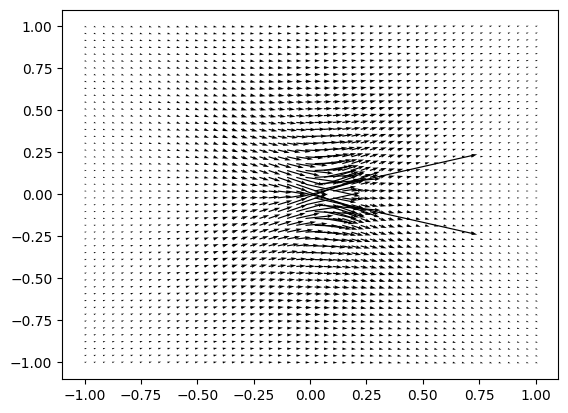

In [29]:
# v[abs(v)>20] = np.nan
plt.quiver(X, Y, v[0], v[1])

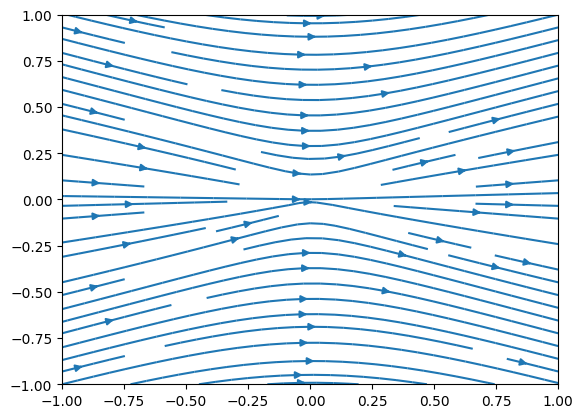

In [30]:
plt.streamplot(X, Y, v[0], v[1])

## Appendix

### A. Small displacement approximation validation

The spring model assumes that the displacement of inner droplet is small compared to the outer droplet size, so that the restoring force is approximately proportional to the displacement in $y$. As we have estimated before, when the displacement goes beyond $r/2$ from equilibrium position, this approximation gets inaccurate. In practice, we want all the trajectory we analyze stay mostly in this range. Therefore, we compute the standard deviation y-displacement $\sigma_y$, and set a criterion $3\sigma_y < (R-r)$ to determine if we use the data in further analysis.

Here, I compute the standard deviation of $y$-position $\sigma_y$ and compute the critical number $c$ as

$$
c = \frac{3\sigma_y}{D-d}
$$

If $c > 0.5$, the trajectory is beyond the scope of the spring model. Otherwise, the spring model is expected to work.

In [263]:
data_folder = r"..\Data"
log = pd.read_excel(io=os.path.join(data_folder, "structured_log_DE.ods"))
c_list = []
for num, i in log.iterrows():
    traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i["DE#"])))
    c = 3 * traj.y.std() * i.MPP / (i.D - i.d) 
    c_list.append(c)

In [75]:
log1 = log.assign(c=c_list)

In [76]:
log1.to_csv("tmpc.csv")

### B. Influence of mean velocity

In [1276]:
log1 = log.dropna(subset=["mean velocity (1s)"])

Text(0, 0.5, 'mean velocity ($\\mu$m/s)')

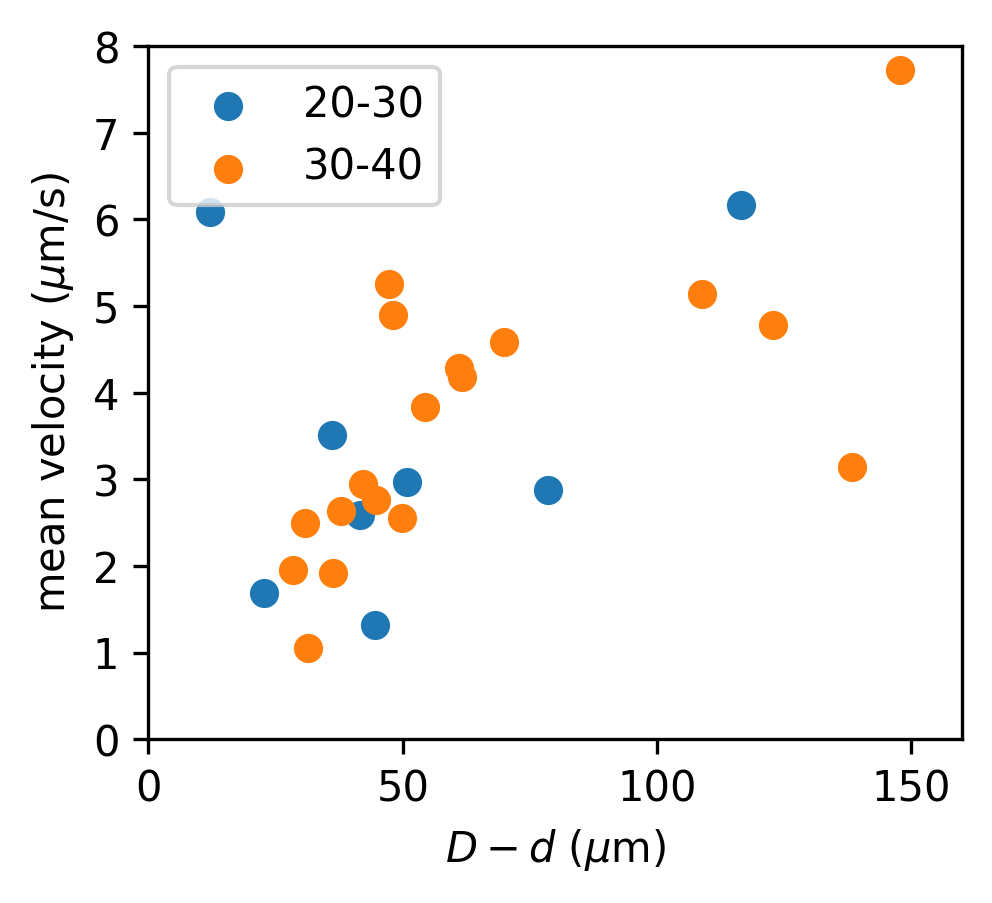

In [1278]:
plt.figure(figsize=(3.5, 3), dpi=300)
log2 = log1.loc[log1.OD <= 30]
log3 = log1.loc[(log1.OD > 30) & (log1.OD<=40)]
plt.scatter(log2["D-d"], log2["mean velocity (1s)"], label="20-30")
plt.scatter(log3["D-d"], log3["mean velocity (1s)"], label="30-40")
plt.legend()
plt.xlim([0, 160])
plt.ylim([0, 8])
plt.xlabel("$D-d$ ($\mu$m)")
plt.ylabel("mean velocity ($\mu$m/s)")

<font color="blue"> The mean velocity data suggests the activity of bacterial suspensions show dependence on the geometry, in particular the free space. However, it's worth noting that the mean velocity is measured by PIV on the whole droplet, including the region of inner droplet. As a result, it does not always faithfully quantify the bacterial activity. In some cases, when inner droplet occupies the majority of the outer droplet, PIV does not make any sense. The low activity of small free space also suggest the possibility that the real underlying control parameter is the total number of bacteria in the droplet. In a typical experiment for example, we have OD=30, corresponding to 2.4e10 cells/ml. In the case where $D=50, d=25$, the total number of bacteria is 1374. This is already small enough that we can hardly expect collective effect from. </font>

In [270]:
D = 50
d = 25
v = 4/3 * np.pi * ((D/2)**3-(d/2)**3) * 1e-12 # ml
number_concentration = 30 * 8e8
nc = v * number_concentration
print("Number of bacteria: {:d}".format(int(nc)))

Number of bacteria: 1374


### C. Total number of bacteria in a droplet

From the calculation above, we notice that in a typical double emulsion, the number of bacteria is not enormous. This leads to a question, do we need certain number of bacteria to constitute strong enough agitation that can make inner droplets fluctuate. To test that, we add an additional column to the structured data, "number of bacteria", and see if it is correlated with $\tau$, $\tau^*$ or $D_A$. 

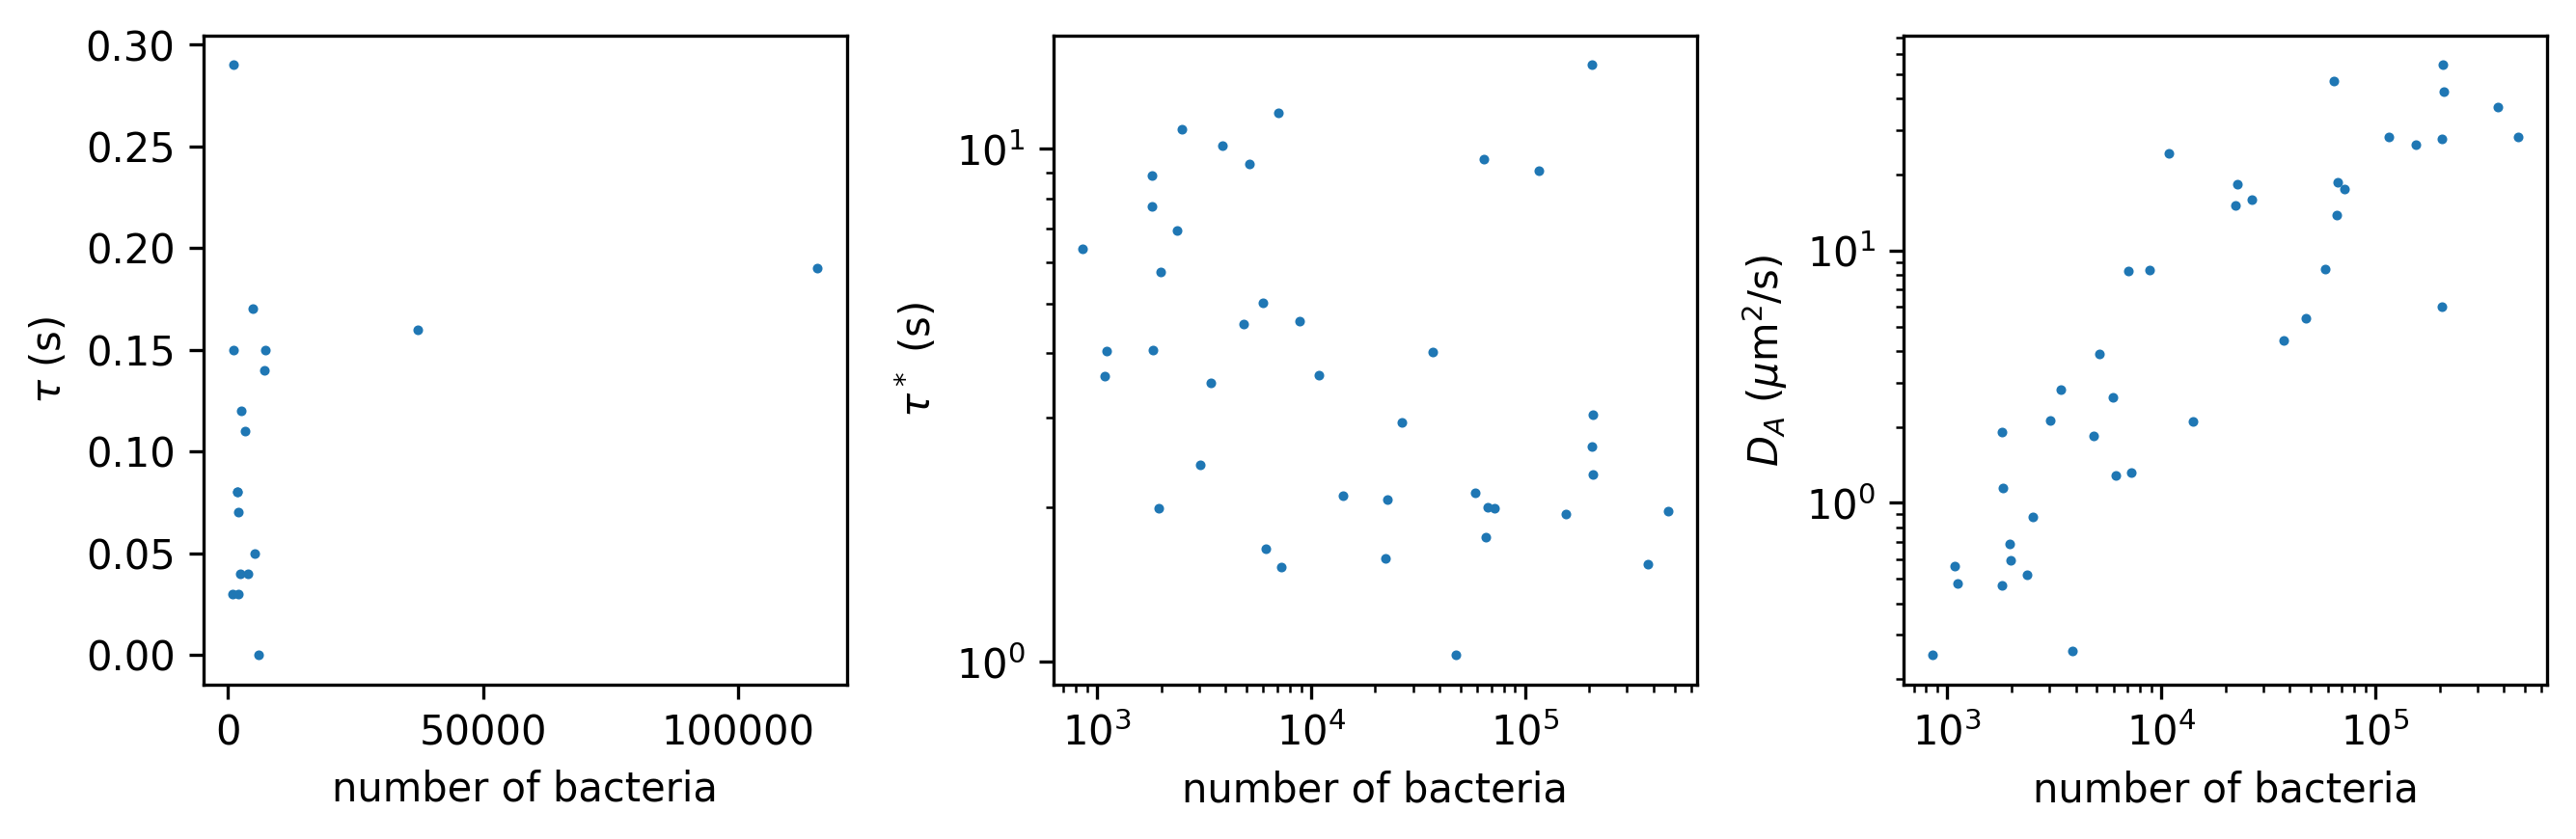

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
ax[0].scatter(log1["number of bacteria"], log1["t1_fit"], s=2)
ax[0].set_xlabel("number of bacteria")
ax[0].set_ylabel("$\\tau$ (s)")
# ax[0].loglog()
ax[1].scatter(log1["number of bacteria"], log1["t2_fit"], s=2)
ax[1].set_xlabel("number of bacteria")
ax[1].set_ylabel("$\\tau^*$ (s)")
ax[1].loglog()
ax[2].scatter(log1["number of bacteria"], log1["DA_fit"], s=2)
ax[2].set_xlabel("number of bacteria")
ax[2].set_ylabel("$D_A$ ($\mu$m$^2$/s)")
ax[2].loglog()

plt.tight_layout()

A few interesting things to note.

1. There is one obvious outlier in the first plot where $\tau = 0.56$ s. This is from DE#171, where $OD=40, D=184.76, d=37.01$. We look at the fitting of the MSD.

![fitting](../images/2022/07/171-fitting.png)

![correction](../images/2022/07/171-correction.png)

Nothing seems too strange up to here. In the video, I notice that besides the largest droplet, there are quite a few smaller droplets moving around the top of the dome and intereracting with the large droplet. This is probably the reason why the behavior of this particular droplet is abnormal. Deeper reason is still not clear.

![171 video](../images/2022/07/large-tau.gif)

2. $\tau^*$ is totally uncorrelated with number of bacteria.
3. $D_A$ shows a nice monotonic increasing trend with number of bacteria.

### D. Create video repo

In [1440]:
from shutil import copyfile

In [1437]:
src = r"C:\Users\liuzy\Documents"
dst = r"C:\Users\liuzy\Google Drive\Research projects\DE\Video-repo"

In [1445]:
log1 = log.loc[log.Comment!="Chile"]

In [1453]:
for num, i in log1.iterrows():
    date = i.Date.strftime("%m%d%Y")
    n = i["Video#"]
    print(num)
    video_dir = os.path.join(src, date, "{:02d}.avi".format(n))
    dst_dir = os.path.join(dst, "{:02d}.avi".format(num))
    if os.path.exists(video_dir) and ~os.path.exists(dst_dir):
        copyfile(video_dir, dst_dir)
    # break

23
24
25
30
32
35
37
38
39
40
41
42
43
44
45
46
48
50
51
52
53
55
56
57
59
64
65
66
67
68
72
75
76
77
78
80
161
162
166
168
171
173
174
175
176
177
178
179
181
182
183
184
185
186
187
189
190
191
192
193
194


### E. Estimate critical inner droplet size

In [6]:
Fa = 6 * np.pi * 0.001 * 0.5e-6 * 20e-6

In [7]:
rc = (Fa / (230 * 9.8 * 4 / 3 * np.pi)) ** (1/3)

In [8]:
rc

2.7128109766122194e-06

### F. Variance $\left< y^2 \right>$ and MSD saturation

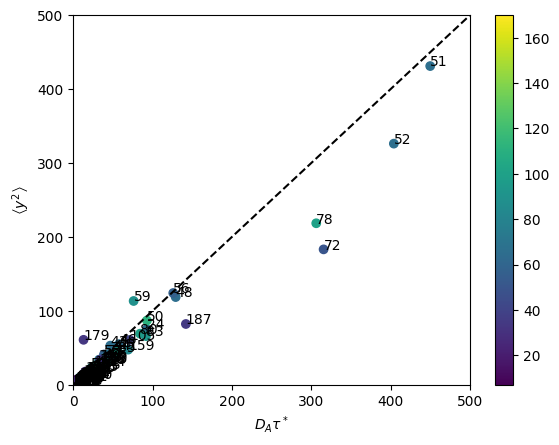

In [10]:
log = pd.read_excel(io=r"../Data/structured_log_DE.ods", sheet_name="main").set_index("DE#")
folder = r"../Data/traj"

log = log.assign(variance=0)

for num, i in log.iterrows():
    traj = pd.read_csv(os.path.join(folder, "{:02d}.csv".format(num)))
    var = (traj.y - traj.y.mean()).std() ** 2 * i.MPP ** 2
    log.at[num, "variance"] = var

plt.scatter(log.DA_fit*log.t2_fit, log.variance, c=log.OD)
plt.xlabel("$D_A\\tau^*$")
plt.ylabel("$\left< y^2 \\right>$")
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.plot([0, 500], [0, 500], ls="--", color="black")
plt.colorbar()
for num, i in log.iterrows():
    plt.annotate(num, (i.DA_fit*i.t2_fit, i.variance), xycoords="data")

### G. Generate clean log file

In the old log, I seldom remove entries, even if some experiments are clearly not good. This is because I think they could be useful some day. Now, as we are coming to the end of this project, I know that these flawed experiments are no longer useful, so I generate a clean log file, which only keeps the data that we are going to use in the plots. Basically, we remove the entries marked by red or orange.

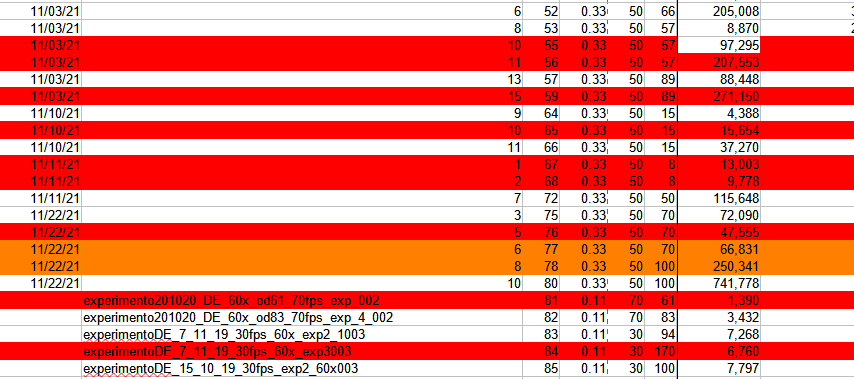

In [21]:
log = pd.read_excel(io=r"C:\Users\liuzy\Documents\Github\DE\Data\structured_log_DE.ods", sheet_name="main")
log1 = log.loc[(log.Fitting!="bad")&(log.Move!=1)]

In [23]:
log1.to_csv("log.csv")

In [1]:
8e-6 * 2 * 230 * 9.8 / 9

0.004007111111111111